## Load Libraries


In [1]:
%load_ext autoreload
%autoreload 2
import os
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"] = "false"
os.environ['MUJOCO_GL'] = 'egl'
os.environ['PYOPENGL_PLATFORM'] = 'egl'
os.environ["XLA_FLAGS"] = "--xla_gpu_triton_gemm_any=True"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"  # Use GPU 0
os.environ["JAX_CAPTURED_CONSTANTS_REPORT_FRAMES"]="-1"
from pathlib import Path
import jax 
jax.config.update("jax_compilation_cache_dir", (Path.cwd() / "tmp/jax_cache").as_posix())
jax.config.update("jax_persistent_cache_min_entry_size_bytes", -1)
jax.config.update("jax_persistent_cache_min_compile_time_secs", 0)
try: 
    jax.config.update("jax_persistent_cache_enable_xla_caches", "xla_gpu_per_fusion_autotune_cache_dir")
except AttributeError:
    pass  # Skip if not available in this JAX version

try:
    import blackjax
except ModuleNotFoundError:
    print('installing blackjax')
    %pip install -qq blackjax
    import blackjax
import matplotlib.pyplot as plt
from natsort import natsorted
# from fastprogress.fastprogress import progress_bar
from functools import partial

# jax.config.update('jax_platform_name', 'cpu')
from jax import random as  jr
from jax import numpy as jnp
from jax import jit, vmap
from itertools import count
from flax import nnx

from tqdm.auto import tqdm
# device = 'gpu' if jax.lib.xla_bridge.get_backend().platform == 'gpu' else 'cpu'
device = 'gpu' if jax.extend.backend.get_backend().platform == 'gpu' else 'cpu'
n_gpus = jax.device_count(backend=device)
print(f"Using {n_gpus} device(s) on {device}")

Using 1 device(s) on gpu


In [2]:
from TiDHy.models.TiDHy_nnx_vmap import TiDHy
from TiDHy.models.TiDHy_nnx_vmap_training import train_model, evaluate_record, load_model, get_latest_checkpoint_epoch, list_checkpoints
from TiDHy.datasets.datasets_dynamax import *
from TiDHy.datasets.load_data import load_data, stack_data
from TiDHy.utils import io_dict_to_hdf5 as ioh5
from TiDHy.utils.path_utils import *

##### Plotting settings ######
import matplotlib as mpl
mpl.rcParams.update({'font.size':          10,
                     'axes.linewidth':     2,
                     'xtick.major.size':   5,
                     'ytick.major.size':   5,
                     'xtick.major.width':  2,
                     'ytick.major.width':  2,
                     'axes.spines.right':  False,
                     'axes.spines.top':    False,
                     'pdf.fonttype':       42,
                     'ps.fonttype':        42,
                     'xtick.labelsize':    10,
                     'ytick.labelsize':    10,
                     'figure.facecolor':   'white',
                     'pdf.use14corefonts': True,
                     'font.family':        'sans-serif',
                    #  'font.family':        'Arial',
                    #  'font.sans-serif':    'Arial',
                     'font.serif':         'Arial',
                    })

from matplotlib.colors import ListedColormap
clrs = ['#1A237E','#7E57C2','#757575','#BDBDBD','#4CAF50','#FF9800','#795548','#FF4081','#00BCD4','#FF1744','#FFFFFF','#000000']
cmap = ListedColormap(clrs)
from sklearn.linear_model import RidgeClassifier,LogisticRegression, RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.decomposition import PCA

def map_discrete_cbar(cmap,N):
    cmap = plt.get_cmap(cmap,N+1)
    bounds = np.arange(-.5,N+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)
    return cmap, norm

def unit_vector(vector):
    """ Returns the unit vector of the vector.  """
    return vector / np.linalg.norm(vector)

def angle_between(v1, v2):
    """ Returns the angle in radians between vectors 'v1' and 'v2'::
    """
    v1_u = unit_vector(v1)
    v2_u = unit_vector(v2)
    return np.arccos(np.clip(np.dot(v1_u, v2_u), -1.0, 1.0))

## Load and run

In [8]:
dataset = 'CalMS21'
# version = 'HierarchicalMultiTimescale'
version = 'TiDHy'
# base_dir = Path(f'/gscratch/portia/eabe/biomech_model/Flybody/{dataset}/{version}')
base_dir = Path(f'/data2/users/eabe/TiDHy/{dataset}/{version}')
run_cfg_list = natsorted(list(Path(base_dir).rglob('run_config.yaml')))
for n, run_cfg in enumerate(run_cfg_list):
    temp = OmegaConf.load(run_cfg)
    print(n, temp.dataset.name, temp.version, run_cfg)

# ###### Load and update config with specified paths template ###### 
cfg_num = 0

# NEW APPROACH: Load config and replace paths using workstation.yaml template
cfg = load_config_and_override_paths(
    config_path=run_cfg_list[cfg_num],
    new_paths_template="workstation",    # Use workstation.yaml for local paths
    config_dir=Path.cwd().parent / "configs",
)

print(f'✅ Loaded experiment: {cfg_num}, {cfg.dataset.name}: {cfg.version} from {run_cfg_list[cfg_num]}')

# Convert string paths to Path objects and create directories
cfg.paths = convert_dict_to_path(cfg.paths)
print("✅ Successfully converted all paths to Path objects and created directories")

0 CalMS21 TiDHy /data2/users/eabe/TiDHy/CalMS21/TiDHy/run_id=option_a01/logs/run_config.yaml
1 CalMS21 TiDHy /data2/users/eabe/TiDHy/CalMS21/TiDHy/run_id=option_a02/logs/run_config.yaml
✅ Loaded experiment: 0, CalMS21: TiDHy from /data2/users/eabe/TiDHy/CalMS21/TiDHy/run_id=option_a01/logs/run_config.yaml
✅ Successfully converted all paths to Path objects and created directories


In [9]:
data_dict = load_data(cfg)
# inputs_train = stack_data(data_dict['inputs_train'], sequence_length=cfg.train.sequence_length, overlap=cfg.train.sequence_length//cfg.train.overlap_factor)
# inputs_test = stack_data(data_dict['inputs_test'], sequence_length=cfg.train.sequence_length, overlap=cfg.train.sequence_length//cfg.train.overlap_factor)
inputs_test = data_dict['inputs_test'][None]

In [10]:
# Create RNG
rngs = nnx.Rngs(0)

# Get model params as dict and unpack directly
model_params = OmegaConf.to_container(cfg.model, resolve=True)
# model_params.pop('batch_converge')
model_params['input_dim'] = inputs_test.shape[-1]

model = TiDHy(**model_params, rngs=rngs)
# model.l0 = nnx.data(jnp.zeros(3))
# model.loss_weights = nnx.data(jnp.ones(3))
print(f"\nModel initialized successfully!")
print(f"input_dim: {model.input_dim}, r_dim: {model.r_dim}, r2_dim: {model.r2_dim}, mix_dim: {model.mix_dim}")
jit_model = jax.jit(model)
# out = jit_model(inputs_train)


Model initialized successfully!
input_dim: 65, r_dim: 16, r2_dim: 8, mix_dim: 8


In [11]:
epoch=get_latest_checkpoint_epoch(cfg.paths.ckpt_dir)
loaded_model = load_model(model,cfg.paths.ckpt_dir/f'epoch_{epoch:04d}')

Model weights loaded from /data2/users/eabe/TiDHy/CalMS21/TiDHy/run_id=option_a01/ckpt/epoch_0700


/home/eabe/miniconda3/envs/rapids-25.10/lib/python3.13/site-packages/orbax/checkpoint/_src/serialization/type_handlers.py:1345: UserWarning: Sharding info not provided when restoring. Populating sharding info from sharding file. Please note restoration time will be slightly increased due to reading from file. Note also that this option is unsafe when restoring on a different topology than the checkpoint was saved with.
  warnings.warn(


In [12]:
rng_key = model.rngs()
spatial_loss_rhat_avg, spatial_loss_rbar_avg, temp_loss_avg, result_dict_single = evaluate_record(loaded_model, inputs_test, rng_key)
result_dict = {}
seq_len = [cfg.train.sequence_length]
result_dict['{}'.format(cfg.train.sequence_length)] = result_dict_single

In [ ]:
result_dict = {}
# seq_len = [100,200,500,1000,2000]
seq_len = [20000]
for seq in tqdm(seq_len):
    inputs_test = stack_data(data_dict['inputs_test'], sequence_length=seq, overlap=seq)
    rng_key = model.rngs()
    spatial_loss_rhat_avg, spatial_loss_rbar_avg, temp_loss_avg, result_dict_single = evaluate_record(loaded_model, inputs_test, rng_key)
    result_dict['{}'.format(seq)] = result_dict_single


In [13]:
W = jnp.stack([result_dict[str(seq)]['W'].reshape(-1, result_dict[str(seq)]['W'].shape[-1]) for seq in seq_len])
I = jnp.stack([result_dict[str(seq)]['I'].reshape(-1, result_dict[str(seq)]['I'].shape[-1]) for seq in seq_len])
Ihat = jnp.stack([result_dict[str(seq)]['I_hat'].reshape(-1, result_dict[str(seq)]['I_hat'].shape[-1]) for seq in seq_len])
Ibar = jnp.stack([result_dict[str(seq)]['I_bar'].reshape(-1, result_dict[str(seq)]['I_bar'].shape[-1]) for seq in seq_len])
R_hat = jnp.stack([result_dict[str(seq)]['R_hat'].reshape(-1, result_dict[str(seq)]['R_hat'].shape[-1]) for seq in seq_len])
R_bar = jnp.stack([result_dict[str(seq)]['R_bar'].reshape(-1, result_dict[str(seq)]['R_bar'].shape[-1]) for seq in seq_len])
R2_hat = jnp.stack([result_dict[str(seq)]['R2_hat'].reshape(-1, result_dict[str(seq)]['R2_hat'].shape[-1]) for seq in seq_len])
Ut = jnp.stack([result_dict[str(seq)]['Ut'].reshape((-1,)+ result_dict[str(seq)]['Ut'].shape[2:]) for seq in seq_len])
W.shape, R2_hat.shape, R_hat.shape, Ut.shape,

((1, 262000, 8), (1, 262000, 8), (1, 262000, 16), (1, 262000, 16, 16))

In [ ]:
for seq in seq_len:
    print(result_dict[str(seq)]['W'].reshape(-1, result_dict[str(seq)]['W'].shape[-1]).shape)

In [ ]:
%load_ext cuml.accel
from sklearn.cross_decomposition import CCA

In [ ]:
cfg.model

In [ ]:
from TiDHy.models.LSTM_baseline import LSTMBaseline
from TiDHy.models.LSTM_training import (
    create_optimizer,
    train_epoch,
    evaluate,
    checkpoint_lstm_model,
    load_lstm_checkpoint,
    discover_lstm_checkpoint,
    evaluate_lstm_record
)
import orbax.checkpoint as ocp
model_params = OmegaConf.to_container(cfg.model, resolve=True)
input_dim = inputs_test.shape[-1]
hidden_dim = model_params['hidden_dim']
num_layers = model_params['num_layers']
dropout_rate = model_params['dropout_rate']
print(input_dim)
rngs = nnx.Rngs(0)
model = LSTMBaseline(
    input_dim=input_dim,
    hidden_dim=hidden_dim,
    output_dim=input_dim,
    num_layers=num_layers,
    dropout_rate=dropout_rate,
    rngs=rngs
)

optimizer_tx = create_optimizer(
    learning_rate=cfg.train.learning_rate,
    weight_decay=cfg.train.weight_decay,
    use_schedule=cfg.train.use_schedule,
    schedule_transition_steps=cfg.train.schedule_transition_steps,
    schedule_decay_rate=cfg.train.schedule_decay,
)
optimizer = nnx.Optimizer(model, optimizer_tx, wrt=nnx.Param)
latest_ckpt = discover_lstm_checkpoint(str(cfg.paths.ckpt_dir))
model, optimizer, start_epoch = load_lstm_checkpoint(
    model, optimizer, str(cfg.paths.ckpt_dir)
)

In [ ]:
test_metrics, result_dict = evaluate_lstm_record(model, inputs_test,)


In [ ]:
I = result_dict['I']
I_hat = result_dict['I_hat']
H = result_dict['H']
C = result_dict['C']
ts = 0
fig, axs = plt.subplots(3,1, figsize=(6,4), sharex=True)
ax = axs[0]
ax.plot(I[ts,:1000,-1])
ax.plot(I_hat[ts,:1000,-1])
ax = axs[1]
ax.plot(H[ts,:1000,0])
ax = axs[2]
ax.plot(C[ts,:1000,0])

In [ ]:
K = 2**cfg.dataset.ssm_params['Nlds']
file_name = f'arhmm_K{K}_L{cfg.get("num_lags",1)}_seed{cfg.seed}.h5'
arhmm_data = ioh5.load(cfg.paths.log_dir / file_name)

In [ ]:
arhmm_data.keys()

In [ ]:
arhmm_data['ground_truth_states_z']
arhmm_data['ARHMM_states']

In [ ]:
plt.plot(arhmm_data['ARHMM_predictions'][:1000,1])
plt.plot(arhmm_data['ground_truth_emissions'][:1000,1])

# Rossler

In [ ]:
n_comps=2
cca = CCA(n_components=2,max_iter=1000)
X_c,Y_c = cca.fit_transform(data_dict['states_x_test'][:,3:],  R_hat[0])
cca_coefficient = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=n_comps)
x_w = cca.x_weights_
y_w = cca.y_weights_
cca_angles = [np.rad2deg(angle_between(X_c[:,n],Y_c[:,n])) for n in range(n_comps)]
cca_angles_x = [np.rad2deg(angle_between(X_c[:,n],data_dict['states_x_test'][:,n])) for n in range(n_comps)]
cca_angles_r = [np.rad2deg(angle_between(Y_c[:,n],R_hat[0,:,n])) for n in range(n_comps)]
for n in range(n_comps):
    print('comp {}, cc: {:.03}, ang: {:.03}, ang_x:{:.03}, ang_r:{:.03}'.format(n,cca_coefficient[n],cca_angles[n],cca_angles_x[n],cca_angles_r[n]))


In [ ]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(121, projection='3d')
ax.plot(X_c[:,0],
        X_c[:,1],
        X_c[:,2],
        lw=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax = fig.add_subplot(122, projection='3d')
ax.plot(Y_c[:,0],
        Y_c[:,1],
        Y_c[:,2],
        lw=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [ ]:
plt.plot(data_dict['inputs_test'][:10000,:],label='input 0')

In [ ]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(121, projection='3d')
ax.plot(data_dict['states_x_test'][:,0],
        data_dict['states_x_test'][:,1],
        data_dict['states_x_test'][:,2],
        lw=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax = fig.add_subplot(122, projection='3d')
ax.plot(data_dict['states_x_test'][:,3],
        data_dict['states_x_test'][:,4],
        data_dict['states_x_test'][:,5],
        lw=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [ ]:
from TiDHy.utils import analyze_hierarchical_rossler_recovery
# Option 2: All-in-one with all three methods
# ============================================
rossler_params = cfg.dataset.rossler_params
dt = cfg.dataset.rossler_params.dt
recovery_analysis = analyze_hierarchical_rossler_recovery(
    model=model,
    test_data=inputs_test,
    rossler_trajectory=data_dict['states_x_test'],
    rossler_params=rossler_params,
    dt=dt,
    rng_key=jax.random.PRNGKey(42),
    tolerance=0.2
)

# Access results
print("\nBasis method:")
print(f"  Recovery: {recovery_analysis['basis_comparison']['recovery_rate']*100:.1f}%")

print("\nEffective method:")
if recovery_analysis['effective_comparison']:
    print(f"  Recovery: {recovery_analysis['effective_comparison']['recovery_rate']*100:.1f}%")

print("\nWeighted method:")
if recovery_analysis['weighted_comparison']:
    print(f"  Recovery: {recovery_analysis['weighted_comparison']['recovery_rate']*100:.1f}%")

# Compare all methods in one plot
comparisons_dict = {
    'Basis': recovery_analysis['basis_comparison'],
    'Effective': recovery_analysis['effective_comparison'],
    'Weighted': recovery_analysis['weighted_comparison']
}
fig, axes = plot_discovered_vs_ground_truth(comparisons_dict)
plt.show()

# Explore plots

In [14]:
from TiDHy.utils import (
    compute_rossler_ground_truth_timescales,
    compare_discovered_to_ground_truth,
    analyze_hierarchical_rossler_recovery,
    plot_discovered_vs_ground_truth,
    analyze_effective_timescales,
)
import cuml
from sklearn.cluster import HDBSCAN, SpectralClustering
from sklearn.preprocessing import StandardScaler
import pandas as pd


Total dimensions: 16
Effective dim (95%): 7
Effective dim (99%): 8
Participation ratio: 6.30


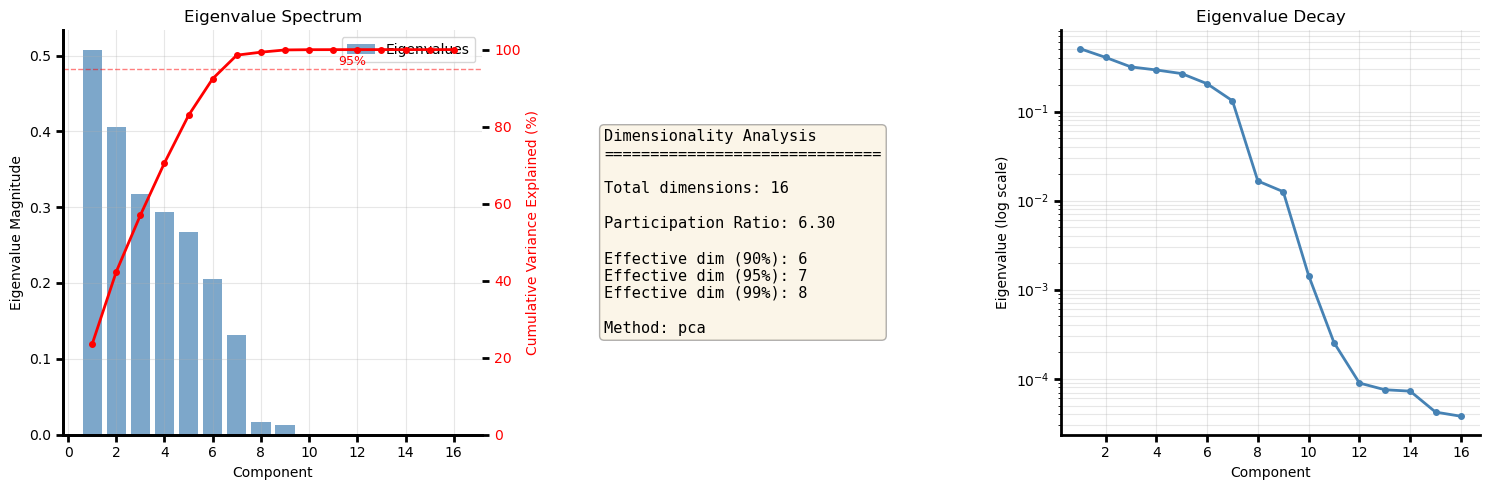

In [15]:
from TiDHy.utils.analysis import analyze_latent_dimension
from TiDHy.utils.analysis_plotting import plot_dimensionality_analysis

ts = -1
# R_hat = result_dict_single['R_hat'].reshape(-1, result_dict_single['R_hat'].shape[-1])

# Analyze effective dimensionality
dim_analysis = analyze_latent_dimension(R_hat[ts], method='pca')

print(f"Total dimensions: {dim_analysis['total_dims']}")
print(f"Effective dim (95%): {dim_analysis['effective_dim_95']}")
print(f"Effective dim (99%): {dim_analysis['effective_dim_99']}")
print(f"Participation ratio: {dim_analysis['participation_ratio']:.2f}")


# Visualize
fig, axes = plot_dimensionality_analysis(dim_analysis)
plt.show()

Discovered timescale range: (0.001447648392058909, 307.2583923339844)
Unique timescales: 60
Stable modes per component: [16, 16, 11, 16, 11, 16, 15, 15, 16, 14, 9, 14, 16, 16, 16, 16, 14, 16, 15, 16, 16, 16, 14, 16, 16, 14, 16, 16, 16, 14, 14, 16, 16, 16, 14, 14, 12, 15, 16, 16, 16, 16, 16, 16, 11, 16, 16, 15, 16, 15, 16, 16, 16, 16, 16, 16, 16, 15, 12, 16, 16, 16, 16, 14, 16, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 15, 12, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 11, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 12, 12, 12, 12, 12, 12, 12, 12, 14, 16, 16, 16, 16, 14, 11, 16, 16, 14, 16, 16, 16, 14, 12, 12, 16, 12, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 12, 11, 16, 16, 16, 11, 12, 16, 16, 16, 16, 14, 12, 15, 16, 16, 14, 15, 16, 15, 12, 16, 16, 16, 16, 16, 15, 12, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 14, 16, 16, 16, 16, 16, 16, 16, 12, 16, 15, 16, 15, 16, 16, 16, 14, 16, 16, 15, 16, 14, 12, 14, 14, 14, 16, 16, 16, 16, 16, 16, 16, 16, 15, 16, 16, 16, 16, 16, 

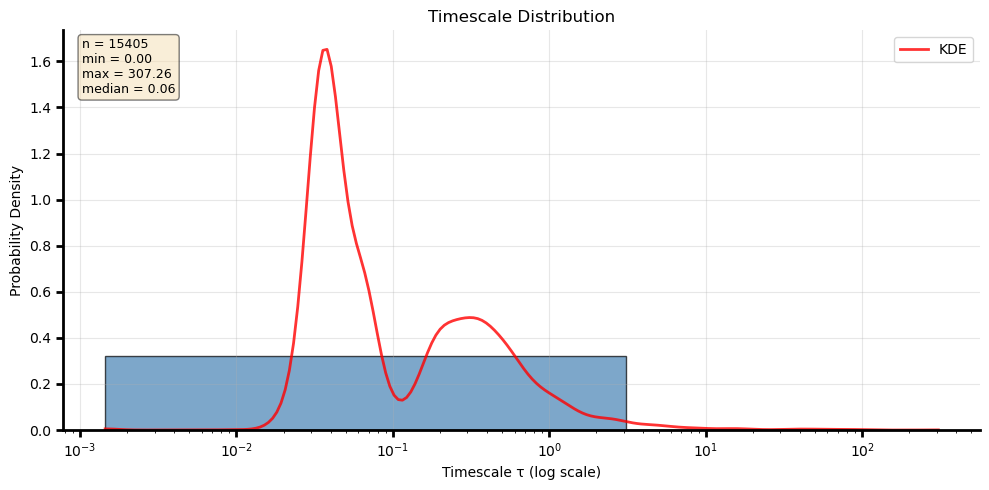

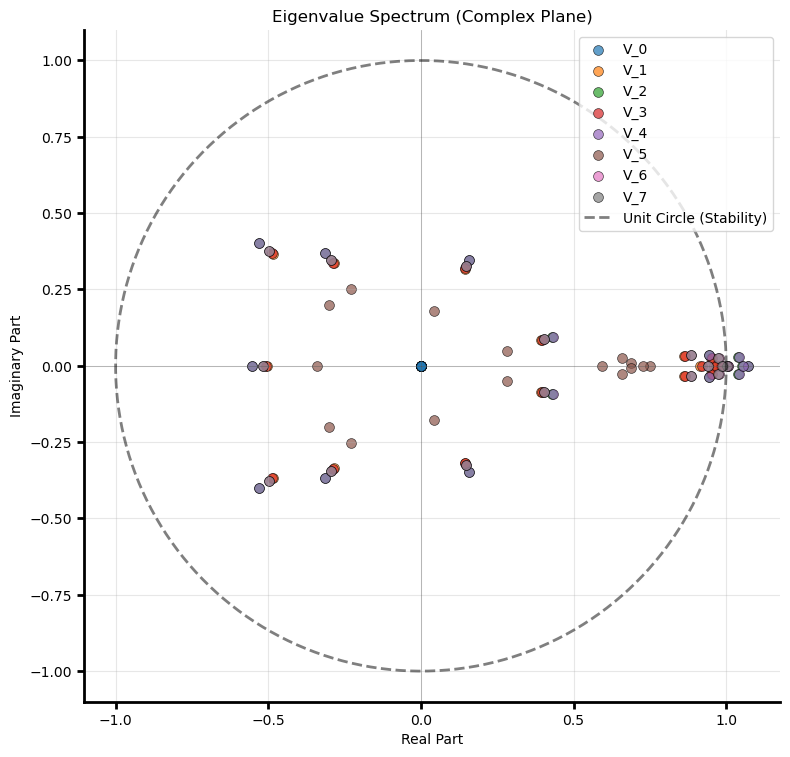

In [16]:
from TiDHy.utils.analysis import analyze_mixture_timescales
from TiDHy.utils.analysis_plotting import plot_timescale_distribution

# Analyze timescales from trained model
# timescale_analysis = analyze_mixture_timescales(model, dt=0.01)
timescale_analysis = analyze_effective_timescales(result_dict_single, dt=1/30)

print(f"Discovered timescale range: {timescale_analysis['timescale_range']}")
print(f"Unique timescales: {len(timescale_analysis['unique_timescales'])}")
print(f"Stable modes per component: {timescale_analysis['n_stable_per_timestep']}")

# Visualize timescale distribution
fig, ax = plt.subplots(figsize=(10, 5))
plot_timescale_distribution(timescale_analysis, ax=ax, bins=100)
plt.show()

# Plot eigenvalues in complex plane for each component
from TiDHy.utils import plot_complex_eigenvalues
eigenvalues_list = [spec['eigenvalues'] for spec in timescale_analysis['spectral_results_sample']]
fig, ax = plt.subplots(figsize=(8, 8))
plot_complex_eigenvalues(eigenvalues_list, ax=ax,
                        component_labels=[f'V_{i}' for i in range(model.mix_dim)])
plt.show()


Active components: 3/8
Entropy (normalized): 0.039
Sparsity: 85.34%
Dominant component: 3


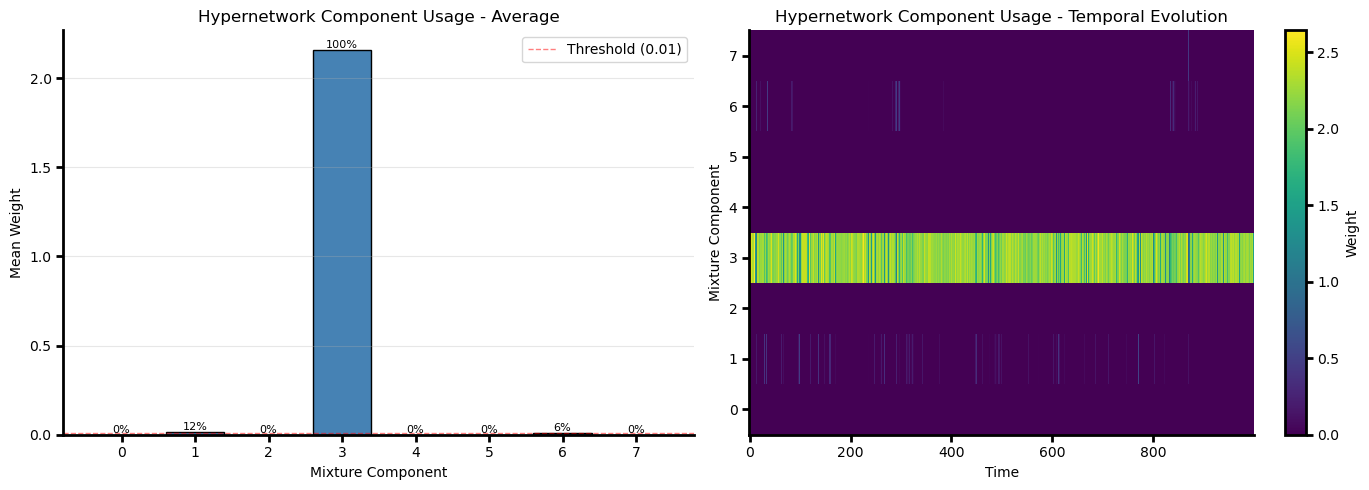

In [17]:

# Example 3: Analyze Hypernetwork Usage

from TiDHy.utils import analyze_hypernetwork_usage, plot_hypernetwork_usage

# W = result_dict_single['W'].reshape(-1, result_dict_single['W'].shape[-1])
ts = -1
# Analyze which components are used
usage_analysis = analyze_hypernetwork_usage(W[ts], threshold=0.01)

print(f"Active components: {usage_analysis['active_components']}/{usage_analysis['mix_dim']}")
print(f"Entropy (normalized): {usage_analysis['entropy']:.3f}")
print(f"Sparsity: {usage_analysis['sparsity']:.2%}")
print(f"Dominant component: {usage_analysis['dominant_component']}")

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
plot_hypernetwork_usage(W, ax=axes)
plt.show()


In [18]:

# Example 4: Combined Model Selection Workflow

from TiDHy.utils import (
    analyze_latent_dimension,
    analyze_mixture_timescales,
    analyze_hypernetwork_usage
)

# 1. Determine effective r_dim
R_analysis = analyze_latent_dimension(result_dict_single['R_hat'])
effective_r_dim = R_analysis['effective_dim_95']

# 2. Determine effective r2_dim  
R2_analysis = analyze_latent_dimension(result_dict_single['R2_hat'])
effective_r2_dim = R2_analysis['effective_dim_95']

# 3. Discover number of timescales (effective mix_dim)
timescale_analysis = analyze_mixture_timescales(model, dt=0.01)
n_unique_timescales = len(timescale_analysis['unique_timescales'])

# 4. Verify with hypernetwork usage
usage_analysis = analyze_hypernetwork_usage(result_dict_single['W'])
active_components = usage_analysis['active_components']

print("\n" + "="*50)
print("MODEL SELECTION SUMMARY")
print("="*50)
print(f"Recommended r_dim:   {effective_r_dim} (current: {model.r_dim})")
print(f"Recommended r2_dim:  {effective_r2_dim} (current: {model.r2_dim})")
print(f"Recommended mix_dim: {active_components} (current: {model.mix_dim})")
print(f"Discovered timescales: {n_unique_timescales}")
print(f"Timescale range: {timescale_analysis['timescale_range']}")


MODEL SELECTION SUMMARY
Recommended r_dim:   7 (current: 16)
Recommended r2_dim:  2 (current: 8)
Recommended mix_dim: 3 (current: 8)
Discovered timescales: 9
Timescale range: (0.00229590549133718, 0.008947883732616901)


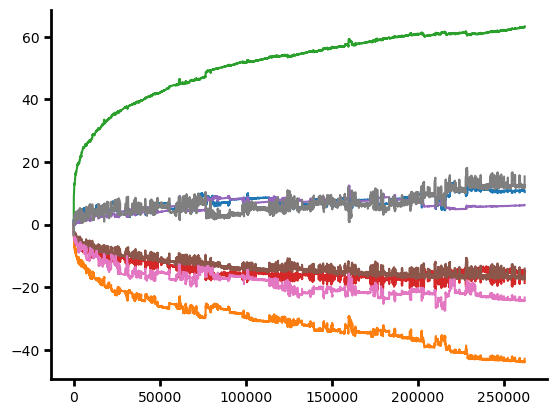

In [19]:
ts = -1
# plt.plot(R2_hat[:,:10000,0].T)
# plt.plot(R_hat[:10000])
plt.plot(R2_hat[ts,:])

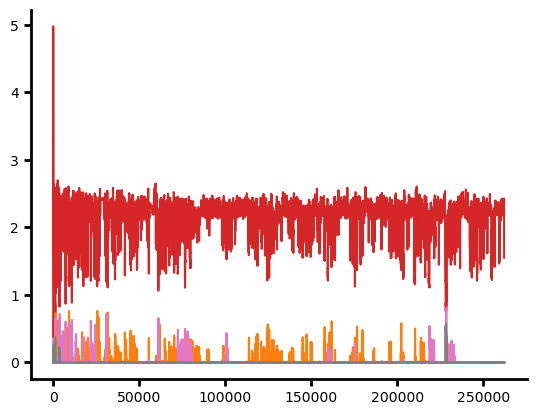

In [20]:
plt.plot(W[0,:,:])

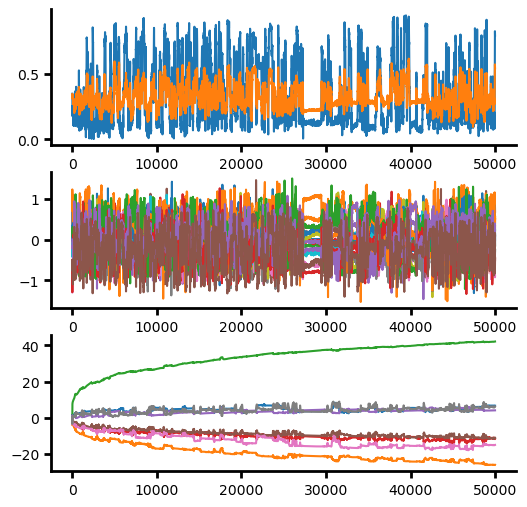

In [21]:
t = 0
dt = 50000
feature = -9
fig, axs = plt.subplots(3,1,figsize=(6,6))
ax = axs[0]
ax.plot(I[ts,t:t+dt,feature],label='I1')
ax.plot(Ihat[ts,t:t+dt,feature],label='Ihat1')
ax = axs[1]
ax.plot(R_hat[ts,t:t+dt,:],label='R_hat')
ax = axs[2]
ax.plot(R2_hat[ts,t:t+dt,:],label='R_2hat')
# ax.plot(Ihat[ts,:10000,2],label='Ihat3')

In [ ]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot(R_hat[:,1],
        R_hat[:,4],
        R_hat[:,5],
        lw=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [ ]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data_dict['inputs_train'][:,0],
        data_dict['inputs_train'][:,1],
        data_dict['inputs_train'][:,2],
        lw=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [ ]:
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data_dict['states_x_train'][:,0],
        data_dict['states_x_train'][:,1],
        data_dict['states_x_train'][:,2],
        lw=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(111, projection='3d')
ax.plot(data_dict['states_x_train'][:,3],
        data_dict['states_x_train'][:,4],
        data_dict['states_x_train'][:,5],
        lw=0.5)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

In [ ]:
effective_results = analyze_effective_timescales(result_dict_single, dt=1/30)
effective_results

In [ ]:
ts = 0
scaler = StandardScaler()
# X_scaled = scaler.fit_transform(W[1])
umap = cuml.manifold.UMAP(n_components=6, n_neighbors=50, min_dist=0.05, metric='euclidean')
reduced_data = umap.fit_transform(R2_hat[ts])

clusterer = cuml.cluster.hdbscan.HDBSCAN(min_cluster_size=500, min_samples=20, cluster_selection_epsilon=0.75, prediction_data=True)
clusterer.fit(reduced_data)
soft_clusters = cuml.cluster.hdbscan.all_points_membership_vectors(clusterer)
labels = clusterer.labels_
l_lab, l_counts = np.unique(labels,return_counts=True)
print(l_lab)
print(l_counts)
print(l_counts[0], sum(l_counts[1:]))

soft_label = jnp.argmax(soft_clusters[:,1:].get() if isinstance(soft_clusters, cuml.common.device_array.DeviceNDArray) else soft_clusters[:,1:], axis=1)
reduced_data = reduced_data.get() if isinstance(reduced_data, cuml.common.device_array.DeviceNDArray) else reduced_data

In [ ]:
full_state_z = data_dict['annotations_test'][:reduced_data.shape[0]]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_data[:,0], reduced_data[:,1], reduced_data[:,2], c=full_state_z, cmap=cmap, alpha=0.1)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
# ax.set_xlim([-10,10])
# ax.set_ylim([-10,10])
# ax.set_zlim([-10,10])
plt.show()

# Load SLDS Model

In [ ]:
import matplotlib.gridspec as gridspec
fontsize=13

clrs = np.array(['#1A237E','#7E57C2','#757575','#BDBDBD','#4CAF50','#FF9800','#795548','#FF4081','#00BCD4','#FF1744','#FFFFFF','#000000'])
sys_clrs = ['#E3A19F','#E3BE53','#708090','#90CCA9','#B7522E','#B0E0E6','#A89AC2','#556B2F','#FF6F61','#87CEEB','#FFDAB9','#40E0D0']
cmap_sys = ListedColormap(sys_clrs)
clr_ind =[8,8,1,1,9,9]
# clr2 = [sys_clrs[clr_ind[n]] for n in range(len(clr_ind))]
clr_ind3 = [2,8,9]
clr2b = [sys_clrs[clr_ind3[n]] for n in range(len(clr_ind3))]

clrs_b = clrs[[0,1,2,9,4,6,7,8,11]]
cmap = ListedColormap(clrs)
# cmap_small = ListedColormap(clrs[:len(np.unique(full_state_z))])
cmap_b = ListedColormap(clrs_b)
cmap
# cmap_b
import itertools
states_x_test = data_dict['states_x_test']
states_z_test = data_dict['states_z_test']
# states_z_test = data_dict['states_z']
ssm_params = cfg.dataset.ssm_params
##### Set up combinatorics of timescales #####
lst = list(itertools.product([1, 0], repeat=3))
lst2 = list(itertools.product(['F', 'S'], repeat=3))
full_state_z = np.zeros(ssm_params['time_bins_test'],dtype=int)
# full_state_z = np.zeros(ssm_params['time_bins_train'],dtype=int)
for n in range(len(lst)):
    full_state_z[np.apply_along_axis(lambda x: np.all(x == lst[n]),0,states_z_test)] = n


In [ ]:
effective_results = analyze_effective_timescales(result_dict_single, dt=1)
effective_results

In [ ]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(R_hat[0])
umap = cuml.manifold.UMAP(n_components=3, n_neighbors=15, min_dist=0.05, metric='euclidean')
reduced_data = umap.fit_transform(X_scaled)

clusterer = cuml.cluster.hdbscan.HDBSCAN(min_cluster_size=100, min_samples=20, cluster_selection_epsilon=0.25, prediction_data=True)
clusterer.fit(reduced_data)
soft_clusters = cuml.cluster.hdbscan.all_points_membership_vectors(clusterer)
labels = clusterer.labels_
l_lab, l_counts = np.unique(labels,return_counts=True)
print(l_lab)
print(l_counts)
print(l_counts[0], sum(l_counts[1:]))

soft_label = jnp.argmax(soft_clusters[:,1:], axis=1)


In [ ]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(reduced_data[:,0],
        reduced_data[:,1],
        reduced_data[:,2],
        c=full_state_z, cmap=cmap_b, alpha=0.05)
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
plt.show()

# Save Multi Seq Len

## Load Results

In [ ]:
slds_dict = ioh5.load('/data2/users/eabe/TiDHy/datasets/SSM/slds_dict.h5')
rslds_dict = ioh5.load('/data2/users/eabe/TiDHy/datasets/SSM/rslds_dict.h5')
SLDS_seed = 11
SLDS_latents = slds_dict[f'seed{SLDS_seed}']['SLDS_latents']
SLDS_states = slds_dict[f'seed{SLDS_seed}']['SLDS_states']
rSLDS_states = rslds_dict[f'seed{SLDS_seed}']['rSLDS_states']
SLDS_emission = slds_dict[f'seed{SLDS_seed}']['SLDS_emission']
rSLDS_emission = rslds_dict[f'seed{SLDS_seed}']['rSLDS_emission']

In [ ]:
from sklearn.linear_model import RidgeClassifier,LogisticRegression, RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
# from statsmodels.tsa.api import VAR

nani = full_state_z.shape[0]
ts=-1
reg_variables = [
    result_dict['{}'.format(seq_len[ts])]['R2_hat'],
    result_dict['{}'.format(seq_len[ts])]['W'],
    result_dict['{}'.format(seq_len[ts])]['R_bar'],
    result_dict['{}'.format(seq_len[ts])]['R_hat'],
    result_dict['{}'.format(seq_len[ts])]['I'],
    SLDS_latents,
    ]

labels = ['R2_hat','W','R_bar','R_hat','I','SLDS']
max_acc = 0
tr_batch_size = 40
batch_size = 10
for k,reg_vars in enumerate(reg_variables):
    X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), full_state_z.reshape(-1), test_size=0.25, random_state=42)
    neigh = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
    neigh.fit(X_train, y_train)
    scores = neigh.score(X_test, y_test)
    print(labels[k],scores)
    if (scores > max_acc) & (labels[k] != 'I'):
        y_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
        max_acc = scores
        best_reg_vars = reg_vars
        best_label = labels[k]
        best_pred = y_pred

# state_compare = np.stack([rSLDS_states, SLDS_states,best_pred,full_state_z],axis=0)
state_compare = np.stack([rSLDS_states, SLDS_states, best_pred,full_state_z],axis=0)



In [ ]:
p=2
(ssm_params['latent_dim']*(p)),(p+1)*ssm_params['latent_dim']

In [ ]:
from TiDHy.utils import compute_timescale_spectrum

In [ ]:
timescales_As = np.hstack([np.sort(np.unique(compute_timescale_spectrum(As[n])['timescales'])) for n in range(As.shape[0])])


In [ ]:
from sklearn.cross_decomposition import CCA
from sklearn.metrics import accuracy_score

n_comps=ssm_params['latent_dim']
t=1500; dt=200
    
fig = plt.figure(constrained_layout=True, figsize=(7,5.5))
gs0 = gridspec.GridSpec(nrows=5,ncols=4, figure=fig, wspace=.45,hspace=.2)

gs00 = gridspec.GridSpecFromSubplotSpec(nrows=6,ncols=1,subplot_spec=gs0[:,:2],wspace=.1,hspace=.2)
# gs01 = gridspec.GridSpecFromSubplotSpec(3,1, subplot_spec=gs0[0:,:1],wspace=.05,hspace=.8)
axs = np.array([fig.add_subplot(gs00[:-3,0]),
                fig.add_subplot(gs00[-3:-2,0]),
                fig.add_subplot(gs00[-2:,0]),
                fig.add_subplot(gs0[:3,2:]),
                fig.add_subplot(gs0[3:,2:])])
axs[4].sharex(axs[3])
ts = -1
##### Pannel a #####
I = result_dict['{}'.format(seq_len[ts])]['I'][0]#.reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])
Ihat = result_dict['{}'.format(seq_len[ts])]['I_hat'][0]#.reshape(-1,result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1])
# fig,axs = plt.subplots(1,2,figsize=(5,3),sharey=True,gridspec_kw={'wspace':.15,'width_ratios':[2,1]})
ax = axs[0]
spacing = 1
xrange = 100
cmap2,norm = map_discrete_cbar(cmap_b,len(np.unique(full_state_z)))
linestyle =  (0, (5, 1))#(0, (5, 5))
hlines_I,hlines_Ihat = [],[]
for n in range(I.shape[-1]):
    mean_centered_I = I[t:t+dt,n] - np.mean(I[t:t+dt,n],axis=0)
    ax.plot(mean_centered_I + n/spacing,color='k', lw=2,zorder=1,label='Data')
    hlines_I.append(np.mean(mean_centered_I + n/spacing,axis=0))
    mean_centered_Ihat = Ihat[t:t+dt,n] - np.mean(Ihat[t:t+dt,n],axis=0)
    ax.plot(mean_centered_Ihat + n/spacing, linestyle=linestyle, color='r', lw=1,zorder=2,label='Pred')
    hlines_Ihat.append(np.mean(mean_centered_Ihat + n/spacing,axis=0))

# ax.set_yticks(hlines_I)
ax.set_yticks([])
# ax.set_yticklabels(np.arange(1,len(hlines_I)+1),fontsize=fontsize-2)
ax.set_ylabel('observations',fontsize=fontsize)
ax.set_xticks(np.arange(0,dt+xrange,xrange))
ax.set_xticklabels(np.arange(0,dt+xrange,xrange),fontsize=fontsize-2)
ax.set_xlabel('timesteps',fontsize=fontsize)

##### Pannel c #####
ax = axs[3]
count=0
acc_slds = accuracy_score(full_state_z, SLDS_states)
acc_rslds = accuracy_score(full_state_z, rSLDS_states)
acc_TiDHy = accuracy_score(full_state_z, y_pred)
spacing = .5
R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'][0]#.reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'][0]#.reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
hlines_x,hlines_Rhat = [],[]
for p in range(ssm_params['Nlds']):
    # states_x_cca = states_x_train[:,(ssm_params['latent_dim']*(p)):(p+1)*ssm_params['latent_dim']]
    # states_x_cca = states_x_test[(ssm_params['latent_dim']*(p)):(p+1)*ssm_params['latent_dim']]
    states_x_cca = states_x_test[p]
    # states_x_cca = states_x_test[:,p:p+1]
    cca = CCA(n_components=ssm_params['latent_dim'],max_iter=1000)
    X_c,Y_c = cca.fit_transform(states_x_cca, R_hat)
    cca_coefficient = np.corrcoef(X_c.T, Y_c.T).diagonal(offset=n_comps)
    x_w = cca.x_weights_
    y_w = cca.y_weights_
    cca_angles = [np.rad2deg(angle_between(X_c[:,n],Y_c[:,n])) for n in range(n_comps)]
    cca_angles_x = [np.rad2deg(angle_between(X_c[:,n],states_x_cca[:,n])) for n in range(n_comps)]
    cca_angles_r = [np.rad2deg(angle_between(Y_c[:,n],R_hat[:,n])) for n in range(n_comps)]
    for n in range(n_comps):
        print('comp {}, cc: {:.03}, ang: {:.03}, ang_x:{:.03}, ang_r:{:.03}'.format(n,cca_coefficient[n],cca_angles[n],cca_angles_x[n],cca_angles_r[n]))

    for i in range(X_c.shape[-1]):
        mean_centered_x = X_c[t:t+dt,i] - np.mean(X_c[t:t+dt,i],axis=0)
        mean_centered_x=mean_centered_x/(np.max(np.abs(mean_centered_x)))
        ax.plot(np.arange(0,dt),mean_centered_x + count/spacing,color='k', lw=2,zorder=1)
        hlines_x.append(np.mean(mean_centered_x + count/spacing,axis=0))
        mean_centered_Rhat = Y_c[t:t+dt,i] - np.mean(Y_c[t:t+dt,i],axis=0)
        mean_centered_Rhat=mean_centered_Rhat/(np.max(np.abs(mean_centered_Rhat)))
        ax.plot(np.arange(0,dt),mean_centered_Rhat + count/spacing,linestyle=linestyle,color='r', lw=1.5,zorder=2,label='$\hat{{r}}_{{{}}}$={:.02}'.format(n,cca_coefficient[n]),alpha=1)
        hlines_Rhat.append(np.mean(mean_centered_Rhat + count/spacing,axis=0))
        ax.text(x=dt+15,y=hlines_x[count],s='cc = {:.02}'.format(cca_coefficient[i]),fontsize=fontsize-2)
        count += 1
    ax.set_yticks(hlines_x) 
    ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
    # ax.set_xlabel('Timesteps',fontsize=fontsize)
    ax.set_ylabel('latent variables',fontsize=fontsize)
# ax.set_xticks([])
ax.set_xticks(np.arange(0,dt+200,200))
ax.set_xticklabels(np.arange(0,dt+200,200),fontsize=fontsize-2)
ax.set_xlabel('timesteps', fontsize=fontsize)
# X,Y = np.meshgrid(np.arange(0,dt),np.arange(-1,2*6))
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(2*6+1,1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
ax.legend(['data','pred'],frameon=False,fontsize=fontsize,loc='upper right',bbox_to_anchor=(1.1,1.1),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=2,columnspacing=.1)

##### Pannel b #####
ax = axs[1]
As = data_dict['As']#.reshape(-1,result_dict['{}'.format(seq_len[ts])]['As'].shape[-1])
dts = 1/len(np.unique(full_state_z))
y_ranges=np.repeat([[0,1]],3,axis=0)
timescales_As = 1/np.abs(np.real(np.log(np.linalg.eigvals(As)))[:,:,0].reshape(-1))
# timescales_As = 1/np.abs(np.log(np.real(np.linalg.eigvals(As)))[:,:,0].reshape(-1))
evals_As = np.linalg.eigvals(As)[:,:,0].reshape(-1)
R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'][0]#.reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'][0]#.reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
Uhat_all = []
for state in range(len(np.unique(full_state_z))):
    rhat2 = R_hat[np.where(full_state_z==state)[0],:]
    Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
    Uhat_all.append(Uhat_0)
    
# for p in range(ssm_params.Nlds):
#     for state in range(ssm_params.n_disc_states):
#         rhat2 = R_hat[np.where(states_z_test[p]==state)[0],:]
#         Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
#         Uhat_all.append(Uhat_0)
        
Uhat_all = np.stack(Uhat_all)
evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
timescales = 1/np.abs(np.real(np.log(evals_Uhat_all)))
min_error_idx = np.array([np.argmin(np.abs(timescales.reshape(-1) - timescales_As.reshape(-1)[n])) for n in range(timescales_As.shape[0])])
min_error_timescales = timescales[min_error_idx]
# timescales = 1/np.abs(np.log(np.real(evals_Uhat_all)))
ax.scatter(x=min_error_timescales,y=np.abs(evals_Uhat_all.reshape(-1)[min_error_idx]), marker='x',
            c='k',s=50,alpha=1,edgecolor='None',zorder=3)
for n in range(len(timescales_As)):
    ax.axvline(x=timescales_As[n],c=sys_clrs[clr_ind[n]])
    ax.scatter(x=timescales_As[n],y=np.abs(evals_As[n]),
            c=sys_clrs[clr_ind[n]],s=40,alpha=1,edgecolor='None')
ax.set_xscale('symlog',linthresh=.1)
ax.set_yticks([0,.5,1])
ax.set_ylim(0,1.1)
ax.set_xlim(0.25,2.5e2)
# ax.set_yticks([np.diff(y_ranges)[0,0]/2 + q*dts for q in range(len(np.unique(full_state_z)))])
# ax.set_yticklabels([''.join(lst2[n]) for n in range(len(lst2))],fontsize=fontsize-2)
# ax.set_xticks([0,-10e0,-10e-1])
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.set_ylabel('|$\lambda$|',fontsize=fontsize)
y = 1
dy = 0.15
ax.annotate('system 1', xy=(.01,y),xycoords='axes fraction',color=sys_clrs[clr_ind[0]],fontsize=fontsize-3.5)
ax.annotate('system 2', xy=(.01,y-dy),xycoords='axes fraction',color=sys_clrs[clr_ind[2]],fontsize=fontsize-3.5)
ax.annotate('system 3', xy=(.01,y-2*dy),xycoords='axes fraction',color=sys_clrs[clr_ind[4]],fontsize=fontsize-3.5)
# ax.set_xticks([0,-10e0,-10e-1])
ax.set_xlabel('timescales',fontsize=fontsize,labelpad=-1)

######### Accuracy and reconstruction error #########
ax = axs[2]
Input_Errors_SLDS = np.abs(I-SLDS_emission)
Input_Errors_rSLDS = np.abs(I-rSLDS_emission)
Input_Errors = np.abs(I-result_dict['{}'.format(seq_len[ts])]['I_hat'][0])
err_slds  = 100*(1-accuracy_score(full_state_z, SLDS_states))
err_rslds = 100*(1-accuracy_score(full_state_z, rSLDS_states))
err_TiDHy = 100*(1-accuracy_score(full_state_z, y_pred))
# ax.scatter(x=np.mean(Input_Errors_SLDS),y=err_slds, s=25, c=clrs[2],label='SLDS')
# ax.errorbar(x=np.mean(Input_Errors_SLDS),y=err_slds, ecolor=clrs[2],xerr=np.std(Input_Errors_SLDS))#/np.sqrt(len(Input_Errors_SLDS)))
# ax.scatter(x=np.mean(Input_Errors_rSLDS),y=err_rslds, s=25,c=clrs[6],label='rSLDS')
# ax.errorbar(x=np.mean(Input_Errors_rSLDS),y=err_rslds, ecolor=clrs[6],xerr=np.std(Input_Errors_rSLDS))#/np.sqrt(len(Input_Errors_SLDS)))
ax.scatter(x=np.mean(Input_Errors),y=err_TiDHy, s=25, c=clrs[1],label='TiDHy')
ax.errorbar(x=np.mean(Input_Errors),y=err_TiDHy, ecolor=clrs[1],xerr=np.std(Input_Errors))#/np.sqrt(len(Input_Errors_SLDS)))
ax.set_yticks([0,25,50,75,100])
ax.set_xlabel('reconstruction error',fontsize=fontsize)
ax.set_ylabel('dyn. % error',fontsize=fontsize)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0),useLocale=True)
ax.legend(frameon=False,fontsize=fontsize-3,loc='upper right',bbox_to_anchor=(1.1,1.1),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=1,columnspacing=.1)

##### Pannel d #####
ax = axs[4]
ylabels_states = ['rSLDS \n {:02}%'.format(int(np.round(acc_rslds*100))),
                  'SLDS \n {:02}%'.format(int(np.round(acc_slds*100))),
                  'TiDHy \n {:02}%'.format(int(np.round(acc_TiDHy*100))),
                  'True']
im = ax.pcolormesh(state_compare[:,t:t+dt],cmap=cmap2,norm=norm,alpha=.5,rasterized=True)
ax.set_xticks(np.arange(0,dt+xrange,xrange))
ax.set_xticklabels(np.arange(0,dt+xrange,xrange),fontsize=fontsize-2)
ax.set_yticks(np.arange(.5,4,1))
ax.set_yticklabels(ylabels_states,fontsize=fontsize-2)
ax.set_xlabel('timesteps',fontsize=fontsize)

cbar = fig.colorbar(im,ax=axs[-1],aspect=10, pad=-.2)

cbar.set_ticks(np.arange(0,len(np.unique(full_state_z)),1))
cbar.set_ticklabels([''.join(lst2[n]) for n in np.arange(len(lst2)-1,-1,-1)],fontsize=fontsize)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")
# fig.tight_layout()
# fig.savefig(cfg.paths.fig_dir/'Benchmark_Compare3.pdf',dpi=300)
# fig.savefig(fig_path/'{}_Fig2_V2.pdf'.format(nfig),dpi=300, transparent=True)


In [ ]:

nani = full_state_z.shape[0]
ts=1
best_pred_all = []
acc_ssm = accuracy_score(full_state_z, SLDS_states)
acc_TiDHy_all = []
for ts in range(len(seq_len)):
    reg_variables = [
        # np.concatenate([result_dict['{}'.format(seq_len[ts])]['R2_hat'],result_dict['{}'.format(seq_len[ts])]['W']],axis=-1)
        result_dict['{}'.format(seq_len[ts])]['R2_hat'],
        # q_lem_x,
        ]

    labels = ['R2_hat']
    # reg_variables = W
    max_acc = 0
    for k,reg_vars in enumerate(reg_variables):
        X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), full_state_z.reshape(-1), test_size=0.25, random_state=42)
        neigh = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
        neigh.fit(X_train, y_train)
        scores = neigh.score(X_test, y_test)
        y_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
        print(labels[k],scores)
        acc_TiDHy = accuracy_score(full_state_z, y_pred)
        acc_TiDHy_all.append(acc_TiDHy)
        best_pred_all.append(y_pred)

state_compare = np.concatenate([SLDS_states[None,:],np.stack(best_pred_all),full_state_z[None,:]],axis=0)



## Load multi-seed

In [ ]:
seq_len = [100,200,500,1000]

result_dict_all = {}
for n in range(len(configs)):
    cfg_path =configs[n]# Path('/data/users/eabe/hypernets/SLDS/DPC_SLDS/TestingNoTempLearning/mix_dim=15/config.yaml')
    default_model_config = '/home/eabe/Research/MyRepos/HyperNets/conf/dataset/model/default_model.yaml'
    cfg = load_cfg(cfg_path, default_model_config)
    cfg, result_dict = run_seq_len_model(seq_len, model, data_dict, device, 1500, cfg, rerun=False)
    result_dict_all['seed_{}'.format(cfg.dataset.ssm_params.seed)] = result_dict

In [ ]:
# Default values
seeds = np.arange(10,10+len(configs))
seed = 10
ts = 200

##### Set up combinatorics of timescales #####
ssm_params = cfg.dataset.ssm_params
lst = list(itertools.product([0, 1], repeat=3))
lst2 = list(itertools.product(['F', 'S'], repeat=3))
full_state_z = np.zeros((len(seeds),ssm_params['time_bins_test']),dtype=int)
# full_state_z = np.zeros(ssm_params['time_bins_train'],dtype=int)
for i, seed in enumerate(seeds):
    for n in range(len(lst)):
        full_state_z[i,np.apply_along_axis(lambda x: np.all(x == lst[n]),0,result_dict_all[f'seed_{seed}'][f'{ts}']['states_z_test'])] = n
    
I_all = np.stack([result_dict_all[f'seed_{seed}'][f'{ts}']['I'] for seed in seeds])
I_hat_all = np.stack([result_dict_all[f'seed_{seed}'][f'{ts}']['I_hat'] for seed in seeds])
R2_hat_all = np.stack([np.stack([result_dict_all[f'seed_{seed}'][f'{ts}']['R2_hat'] for ts in seq_len])for seed in seeds])  # (n_seeds, Time, Z_dim)
R_bar_all = np.stack([np.stack([result_dict_all[f'seed_{seed}'][f'{ts}']['R_bar'] for ts in seq_len]) for seed in seeds])   # (n_seeds, TempWinN, Time, r2_dim)
R_hat_all = np.stack([np.stack([result_dict_all[f'seed_{seed}'][f'{ts}']['R_hat'] for ts in seq_len]) for seed in seeds])   # (n_seeds, TempWinN, Time, r_dim)
W_all = np.stack([np.stack([result_dict_all[f'seed_{seed}'][f'{ts}']['W'] for ts in seq_len]) for seed in seeds])           # (n_seeds, TempWinN, Time, r_dim)
As_all = np.stack([np.stack([v for v in result_dict_all[f'seed_{seed}'][f'{ts}']['As'].values()]) for seed in seeds])
result_dict_all[f'seed_{seed}'][f'{ts}'].keys()

In [ ]:
import pickle
from ssm.util import random_rotation, find_permutation
inputs_train_SLDS=data_dict['inputs_train']
inputs_test_SLDS=data_dict['inputs_test']
seed = cfg.dataset.ssm_params['seed']
TotalTime = cfg.dataset.ssm_params.time_bins_test
# SLDS_path = Path('/data/users/eabe/hypernets/SLDS/TiDHy_SLDS/L1ShortWin/L1_alpha=0.001,dataset.ssm_params.seed=10,dataset.train.sequence_length=200')
N = inputs_train_SLDS.shape[-1]
K = len(np.unique(full_state_z))
D = data_dict['states_x_test'].shape[-1]
SLDS_latents = np.zeros((len(seeds),TotalTime,D))
SLDS_states = np.zeros((len(seeds),TotalTime))
SLDS_emission = np.zeros((len(seeds),TotalTime,N))
rSLDS_latents = np.zeros((len(seeds),TotalTime,D))
rSLDS_states = np.zeros((len(seeds),TotalTime))
rSLDS_emission = np.zeros((len(seeds),TotalTime,N))
for k, seed in enumerate(seeds):
    SLDS_path = configs[k].parent#/'SSM/DPC_SSM/Benchmark/dataset.ssm_params.seed={}/'.format(seed)
    with open(SLDS_path/'ssm_slds_test_full_{}D_{}K_{}seed.pickle'.format(D,K,seed), 'rb') as handle:
    # with open(cfg.paths.data_dir/'ssm_rslds_test.pickle', 'rb') as handle:
        slds = pickle.load(handle)
        posterior = pickle.load(handle)
        SLDS_latents[k] = pickle.load(handle)
        SLDS_states[k] = pickle.load(handle)
        SLDS_emission[k] = pickle.load(handle)

    with open(SLDS_path/'ssm_rslds_test_full_{}D_{}K_{}seed.pickle'.format(D,K,seed), 'rb') as handle:
    # with open(cfg.paths.data_dir/'ssm_rslds_test.pickle', 'rb') as handle:
        slds = pickle.load(handle)
        posterior = pickle.load(handle)
        rSLDS_latents[k] = pickle.load(handle)
        rSLDS_states[k] = pickle.load(handle)
        rSLDS_emission[k] = pickle.load(handle)


In [ ]:
from sklearn.linear_model import RidgeClassifier,LogisticRegression, RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
# from statsmodels.tsa.api import VAR

nani = full_state_z.shape[0]
ts=-1

labels = seeds
max_acc = 0
tr_batch_size = 40
batch_size = 10
scores_all = []
pred_all = np.zeros((len(seeds),len(seq_len),cfg.dataset.ssm_params.time_bins_test))
for k in range(len(seeds)):
    for ts in range(len(seq_len)):
        X_train, X_test, y_train, y_test = train_test_split(R2_hat_all[k,ts], full_state_z[k].reshape(-1), test_size=0.25, random_state=42)
        neigh = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
        neigh.fit(X_train, y_train)
        scores = neigh.score(X_test, y_test)
        y_pred = neigh.predict(R2_hat_all[k,ts])
        pred_all[k,ts] = y_pred
        scores_all.append(accuracy_score(full_state_z[k].reshape(-1),y_pred))
        print(labels[k],seq_len[ts],scores)
        if (scores > max_acc) & (labels[k] != 'I'):
            max_acc = scores
            best_label = k
            best_pred = y_pred

# state_compare = np.stack([rSLDS_states, SLDS_states,best_pred,full_state_z[best_label]],axis=0)

scores_all = np.stack(scores_all).reshape(len(seeds),len(seq_len))

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(8,6))
gs0 = gridspec.GridSpec(nrows=4,ncols=2, figure=fig, wspace=.15,hspace=.2)
axs = np.array([fig.add_subplot(gs0[:2,0]),fig.add_subplot(gs0[2:,0]),fig.add_subplot(gs0[:2,1]),fig.add_subplot(gs0[2:,1])])
t=1500; dt=1000
# seq_len=[100,200,500]
ts = 1
Input_Errors_SLDS = (I_all[k]-SLDS_emission[k])
ax = axs[-1]
Input_Errors_SLDS = np.mean([np.abs(I_all[k]-SLDS_emission[k]) for k in range(len(seeds))],axis=-1)
Input_Errors_rSLDS = np.mean([np.abs(I_all[k]-rSLDS_emission[k]) for k in range(len(seeds))],axis=-1)
err_slds  = np.mean([100*(1-accuracy_score(full_state_z[k], SLDS_states[k])) for k in range(len(seeds))])
err_rslds = np.mean([100*(1-accuracy_score(full_state_z[k], rSLDS_states[k])) for k in range(len(seeds))])
for ts in range(len(seq_len)):
    Input_Errors =np.stack([np.abs(I_all[seed,ts]-I_hat_all[seed,ts]) for seed in range(len(seeds))])
    err_TiDHy = np.mean([100*(1-accuracy_score(full_state_z[k], pred_all[k,ts])) for k in range(len(seeds))])
    ax.scatter(x=np.mean(Input_Errors),y=err_TiDHy, s=25, c=clrs_b[ts],label='TiDHy')
    ax.errorbar(x=np.mean(Input_Errors),y=err_TiDHy, ecolor=clrs_b[ts],xerr=np.mean(np.std(Input_Errors,axis=-1)),yerr=np.mean(np.std(Input_Errors,axis=0)))#/np.sqrt(len(Input_Errors_SLDS)))

ax.scatter(x=np.mean(Input_Errors_SLDS),y=err_slds, s=25, c=clrs[2],label='SLDS')
ax.errorbar(x=np.mean(Input_Errors_SLDS),y=err_slds, ecolor=clrs[2],xerr=np.std(Input_Errors_SLDS))#/np.sqrt(len(Input_Errors_SLDS)))
ax.scatter(x=np.mean(Input_Errors_rSLDS),y=np.mean(err_rslds), s=25,c=clrs[6],label='rSLDS')
ax.errorbar(x=np.mean(Input_Errors_rSLDS),y=np.mean(err_rslds), ecolor=clrs[6],xerr=np.std(Input_Errors_rSLDS))#/np.sqrt(len(Input_Errors_SLDS)))
ax.set_yticks([0,25,50,75,100])
ax.set_xlabel('reconstruction error',fontsize=fontsize)
ax.set_ylabel('dyn. % error',fontsize=fontsize)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0),useLocale=True)
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.tick_params(axis='y', labelsize=fontsize-2)
y = .95
dy = 0.075
for tts in range(len(seq_len)):
    ax.annotate('T={}'.format(seq_len[tts]), xy=(.8,y-tts*dy),xycoords='axes fraction',color=clrs_b[tts],fontsize=fontsize-2)
tts+=1
ax.annotate('SLDS', xy=(.8,y-tts*dy),xycoords='axes fraction',color=clrs[2],fontsize=fontsize-2)
tts += 1
ax.annotate('rSLDS', xy=(.8,y-tts*dy),xycoords='axes fraction',color=clrs[6],fontsize=fontsize-2)


states_z_test = data_dict['states_z_test']
ax = axs[2]
As = np.stack([v for v in data_dict['As'].values()])
timescales_As = 1/np.abs(np.real(np.log(np.linalg.eigvals(As)))[:,:,0].reshape(-1))
# timescales_As = 1/np.abs(np.log(np.real(np.linalg.eigvals(As)))[:,:,0].reshape(-1))
ts = 0
dts = 1/len(seq_len)
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(seq_len))[:,(0,-1)]
for ts in range(len(seq_len)):
    for seed in seeds: 
        R_bar = result_dict_all['seed_{}'.format(seed)]['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
        R_hat = result_dict_all['seed_{}'.format(seed)]['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])

        ##### Plottign Eigenvalues #####
        Uhat_all = []
        for state in range(len(np.unique(full_state_z[0]))):
            # rhat2 = R_hat[np.where(full_state_z==state)[0],:]
            # model = VAR(rhat2)
            # results = model.fit(maxlags=20,ic='aic')
            # eig_Ut = np.linalg.eigvals(results.coefs).reshape(-1)
            # Uhat_all.append(eig_Ut.reshape(-1))
        # for p in range(ssm_params.Nlds):
        #     for state in range(ssm_params.n_disc_states):
                # rhat2 = R_hat[np.where(states_z_test[p]==state)[0],:]
            rhat2 = R_hat[np.where(full_state_z[0]==state)[0],:]
            Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
            Uhat_all.append(Uhat_0)

        Uhat_all = np.stack(Uhat_all)
        # evals_Uhat_all = np.hstack(Uhat_all)
        # timescales = 1/np.abs(np.log(np.real(evals_Uhat_all)))
        # timescales = np.real(np.log(Uhat_all))
        evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
        timescales = 1/np.abs(np.real(np.log(evals_Uhat_all)))
        # timescales = 1/np.abs(np.log(np.real(evals_Uhat_all)))
        min_error_idx = np.array([np.argmin(np.abs(timescales.reshape(-1) - timescales_As.reshape(-1)[n])) for n in range(timescales_As.shape[0])])
        min_error_timescales = timescales[min_error_idx]
        ax.scatter(x=min_error_timescales,y=np.abs(evals_Uhat_all.reshape(-1)[min_error_idx])+ts,
                c=clrs_b[ts],alpha=.75,edgecolor='None',marker='x',s=25,zorder=3)

    for n in range(len(timescales_As)):
        ax.axvline(x=timescales_As[n],c=sys_clrs[clr_ind[n]])
        ax.axhline(y=ts,c=clrs_b[ts],linestyle='--',zorder=-1)
    # ax = plot_hist(timescales,-1.75,.1,.1,ax,'TiDHy',clr=clrs_b[ts])
    ax.set_xscale('symlog',linthresh=.1)
    ax.set_yticks([1/2 + q for q in range(len(seq_len))])
    ax.set_yticklabels(seq_len,fontsize=fontsize-2)
    ax.set_ylabel('T',fontsize=fontsize,labelpad=-2)
    # ax.spines.left.set_visible(False)
    ax.set_xlabel('timescales',fontsize=fontsize,labelpad=-3)
# ax.set_xticks([0,-10e0,-10e-1])
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.set_xscale('symlog',linthresh=.015)
y = .99
dy = 0.075
ax.annotate('System 1', xy=(.01,y),xycoords='axes fraction',color=sys_clrs[clr_ind[0]],fontsize=fontsize-2)
ax.annotate('System 2', xy=(.01,y-dy),xycoords='axes fraction',color=sys_clrs[clr_ind[2]],fontsize=fontsize-2)
ax.annotate('System 3', xy=(.01,y-2*dy),xycoords='axes fraction',color=sys_clrs[clr_ind[4]],fontsize=fontsize-2)

ax=axs[0]
spacing= 5
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['R_hat'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['R_hat'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_ylabel('$\hat{r}$',fontsize=fontsize,labelpad=-2)
ax.set_xlabel('timesteps',fontsize=fontsize)
ax.set_xticks(np.arange(0,dt+(dt//4),(dt)//4))
ax.set_xticklabels(np.arange(0,dt+(dt//4),(dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
ax.set_xlim([0,dt])
y = .95
dy = 0.075
for tts in range(len(seq_len)):
    ax.annotate('T={}'.format(seq_len[tts]), xy=(1.05,y-tts*dy),xycoords='axes fraction',color=clrs_b[tts],fontsize=fontsize-2)

# legend = ax.legend(['T={}'.format(seq_len[p]) for p in range(len(seq_len))],frameon=False,fontsize=fontsize,loc='upper right',
#           bbox_to_anchor=(1.25,1),labelcolor=clrs_b,handlelength=0,handleheight=0,ncols=1)


ax = axs[1]
state_compare = np.concatenate([SLDS_states[:1,:],pred_all[0],full_state_z[:1,:]],axis=0)
cmap2,norm = map_discrete_cbar(cmap_b,len(np.unique(full_state_z[0])))
acc_slds = accuracy_score(full_state_z[0], SLDS_states[0])
TiDHy_acc = ['T={} \n {:02}%'.format(seq_len[n],int(np.round(scores_all[0,n]*100))) for n in range(len(scores_all[0]))]
Ylabels = ['SLDS \n {:02}%'.format(int(np.round(acc_slds*100)))] + TiDHy_acc + ['True']  
im = ax.pcolormesh(state_compare[:,t:t+dt],cmap=cmap2,norm=norm,alpha=.5,rasterized=True)
# ax.set_xticks(np.arange(0,dt+200,200))
# ax.set_xticklabels(np.arange(0,dt+200,200),fontsize=fontsize)
ax.set_xticks(np.arange(0,dt+(dt//4),(dt)//4))
ax.set_xticklabels(np.arange(0,dt+(dt//4),(dt)//4),fontsize=fontsize-2)
ax.set_yticks(np.arange(.5,len(Ylabels),1))
ax.set_yticklabels(Ylabels,fontsize=fontsize-2)
ax.set_xlabel('timesteps',fontsize=fontsize)

cbar = fig.colorbar(im,ax=ax,aspect=10, pad=-.2)
cbar.set_ticks(np.arange(0,len(np.unique(full_state_z)),1))
cbar.set_ticklabels([''.join(lst2[n]) for n in np.arange(len(lst2)-1,-1,-1)],fontsize=fontsize)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")
fig.savefig(fig_path/'{}_Fig3.pdf'.format(0),dpi=300)


In [ ]:
ts = 1
Input_Errors = np.abs(I-result_dict['{}'.format(seq_len[ts])]['I_hat'])
np.mean(Input_Errors),np.std(Input_Errors)

In [ ]:
fig = plt.figure(constrained_layout=True, figsize=(8,6))
gs0 = gridspec.GridSpec(nrows=4,ncols=2, figure=fig, wspace=.15,hspace=.2)
axs = np.array([fig.add_subplot(gs0[:2,0]),fig.add_subplot(gs0[2:,0]),fig.add_subplot(gs0[:2,1]),fig.add_subplot(gs0[2:,1])])
t=1500; dt=1000
# seq_len=[100,200,500]

Input_Errors_SLDS = (inputs_test_SLDS-SLDS_emission)
ax = axs[0]
Input_Errors_SLDS = np.abs(inputs_test_SLDS-SLDS_emission)
Input_Errors_rSLDS = np.abs(inputs_test_SLDS-rSLDS_emission)
err_slds  = 100*(1-accuracy_score(full_state_z, SLDS_states))
err_rslds = 100*(1-accuracy_score(full_state_z, rSLDS_states))
for ts in range(len(seq_len)):
    Input_Errors = np.abs(I-result_dict['{}'.format(seq_len[ts])]['I_hat'])
    err_TiDHy = 100*(1-accuracy_score(full_state_z, y_pred))
    ax.scatter(x=np.mean(Input_Errors),y=err_TiDHy, s=25, c=clrs_b[ts],label='TiDHy')
    ax.errorbar(x=np.mean(Input_Errors),y=err_TiDHy, ecolor=clrs_b[ts],xerr=np.std(Input_Errors))#/np.sqrt(len(Input_Errors_SLDS)))

ax.scatter(x=np.mean(Input_Errors_SLDS),y=err_slds, s=25, c=clrs[2],label='SLDS')
ax.errorbar(x=np.mean(Input_Errors_SLDS),y=err_slds, ecolor=clrs[2],xerr=np.std(Input_Errors_SLDS))#/np.sqrt(len(Input_Errors_SLDS)))
ax.scatter(x=np.mean(Input_Errors_rSLDS),y=err_rslds, s=25,c=clrs[6],label='rSLDS')
ax.errorbar(x=np.mean(Input_Errors_rSLDS),y=err_rslds, ecolor=clrs[6],xerr=np.std(Input_Errors_rSLDS))#/np.sqrt(len(Input_Errors_SLDS)))
ax.set_yticks([0,25,50,75,100])
ax.set_xlabel('reconstruction error',fontsize=fontsize)
ax.set_ylabel('dyn. % error',fontsize=fontsize)
ax.ticklabel_format(axis='x', style='sci', scilimits=(0,0),useLocale=True)
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.tick_params(axis='y', labelsize=fontsize-2)
y = .95
dy = 0.075
for tts in range(len(seq_len)):
    ax.annotate('T={}'.format(seq_len[tts]), xy=(.8,y-tts*dy),xycoords='axes fraction',color=clrs_b[tts],fontsize=fontsize-2)
tts+=1
ax.annotate('SLDS', xy=(.8,y-tts*dy),xycoords='axes fraction',color=clrs[2],fontsize=fontsize-2)
tts += 1
ax.annotate('rSLDS', xy=(.8,y-tts*dy),xycoords='axes fraction',color=clrs[6],fontsize=fontsize-2)


states_z_test = data_dict['states_z_test']
ax = axs[1]
As = np.stack([v for v in data_dict['As'].values()])
timescales_As = 1/np.abs(np.real(np.log(np.linalg.eigvals(As)))[:,:,0].reshape(-1))
ts = 0
dts = 1/len(seq_len)
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(seq_len))[:,(0,-1)]
for ts in range(len(seq_len)):
    R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
    R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])

    ##### Plottign Eigenvalues #####
    Uhat_all = []
    for state in range(len(np.unique(full_state_z))):
        # rhat2 = R_hat[np.where(full_state_z==state)[0],:]
        # model = VAR(rhat2)
        # results = model.fit(maxlags=20,ic='aic')
        # eig_Ut = np.linalg.eigvals(results.coefs).reshape(-1)
        # Uhat_all.append(eig_Ut.reshape(-1))
    # for p in range(ssm_params.Nlds):
    #     for state in range(ssm_params.n_disc_states):
            # rhat2 = R_hat[np.where(states_z_test[p]==state)[0],:]
        rhat2 = R_hat[np.where(full_state_z==state)[0],:]
        Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
        Uhat_all.append(Uhat_0)

    Uhat_all = np.stack(Uhat_all)
    # evals_Uhat_all = np.hstack(Uhat_all)
    # timescales = 1/np.abs(np.log(np.real(evals_Uhat_all)))
    # timescales = np.real(np.log(Uhat_all))
    evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
    timescales = 1/np.abs(np.real(np.log(evals_Uhat_all)))
    
    ax.scatter(x=timescales,y=np.abs(evals_Uhat_all)+ts,
               c=clrs_b[ts],alpha=.75,edgecolor='None',s=25)

    for n in range(len(timescales_As)):
        ax.axvline(x=timescales_As[n],c=sys_clrs[clr_ind[n]])
        ax.axhline(y=ts,c=clrs_b[ts],linestyle='--',zorder=-1)
    # ax = plot_hist(timescales,-1.75,.1,.1,ax,'TiDHy',clr=clrs_b[ts])
    ax.set_xscale('symlog',linthresh=.1)
    ax.set_yticks([1/2 + q for q in range(len(seq_len))])
    ax.set_yticklabels(seq_len,fontsize=fontsize-2)
    ax.set_ylabel('T',fontsize=fontsize,labelpad=-2)
    # ax.spines.left.set_visible(False)
    ax.set_xlabel('timescales',fontsize=fontsize,labelpad=-3)
# ax.set_xticks([0,-10e0,-10e-1])
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.set_xscale('symlog',linthresh=.015)
y = .99
dy = 0.075
ax.annotate('System 1', xy=(.01,y),xycoords='axes fraction',color=sys_clrs[clr_ind[0]],fontsize=fontsize-2)
ax.annotate('System 2', xy=(.01,y-dy),xycoords='axes fraction',color=sys_clrs[clr_ind[2]],fontsize=fontsize-2)
ax.annotate('System 3', xy=(.01,y-2*dy),xycoords='axes fraction',color=sys_clrs[clr_ind[4]],fontsize=fontsize-2)

ax=axs[2]
spacing= 5
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['R_hat'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['R_hat'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_ylabel('$\hat{r}$',fontsize=fontsize,labelpad=-2)
ax.set_xlabel('timesteps',fontsize=fontsize)
ax.set_xticks(np.arange(0,dt+(dt//4),(dt)//4))
ax.set_xticklabels(np.arange(0,dt+(dt//4),(dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
ax.set_xlim([0,dt])
y = .95
dy = 0.075
for tts in range(len(seq_len)):
    ax.annotate('T={}'.format(seq_len[tts]), xy=(1.05,y-tts*dy),xycoords='axes fraction',color=clrs_b[tts],fontsize=fontsize-2)

# legend = ax.legend(['T={}'.format(seq_len[p]) for p in range(len(seq_len))],frameon=False,fontsize=fontsize,loc='upper right',
#           bbox_to_anchor=(1.25,1),labelcolor=clrs_b,handlelength=0,handleheight=0,ncols=1)


ax = axs[3]
TiDHy_acc = ['T={} \n {:02}%'.format(seq_len[n],int(np.round(acc_TiDHy_all[n]*100))) for n in range(len(acc_TiDHy_all))]
Ylabels = ['SLDS \n {:02}%'.format(int(np.round(acc_ssm*100)))] + TiDHy_acc + ['True']  
im = ax.pcolormesh(state_compare[:,t:t+dt],cmap=cmap2,norm=norm,alpha=.5,rasterized=True)
# ax.set_xticks(np.arange(0,dt+200,200))
# ax.set_xticklabels(np.arange(0,dt+200,200),fontsize=fontsize)
ax.set_xticks(np.arange(0,dt+(dt//4),(dt)//4))
ax.set_xticklabels(np.arange(0,dt+(dt//4),(dt)//4),fontsize=fontsize-2)
ax.set_yticks(np.arange(.5,len(Ylabels),1))
ax.set_yticklabels(Ylabels,fontsize=fontsize-2)
ax.set_xlabel('timesteps',fontsize=fontsize)

cbar = fig.colorbar(im,ax=ax,aspect=10, pad=-.2)
cbar.set_ticks(np.arange(0,len(np.unique(full_state_z)),1))
cbar.set_ticklabels([''.join(lst2[n]) for n in np.arange(len(lst2)-1,-1,-1)],fontsize=fontsize)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")
fig.savefig(cfg.paths.fig_dir/'{}_Fig3.pdf'.format(nfig),dpi=300)


In [ ]:
# Trade off plot between accuracy of reconstruction and correct identification of unique timescales

In [ ]:
fig, axs = plt.subplots(1,1,figsize=(5,3))
ax = axs
dts = 1/len(np.unique(full_state_z))
y_ranges=np.repeat([[0,1]],3,axis=0)
timescales_As = 1/np.abs(np.real(np.log(np.linalg.eigvals(As)))[:,:,0].reshape(-1))
evals_As = np.linalg.eigvals(As)[:,:,0].reshape(-1)
R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
Uhat_all = []
for state in range(len(np.unique(full_state_z))):
    rhat2 = R_hat[np.where(full_state_z==state)[0],:]
    Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
    Uhat_all.append(Uhat_0)
    
# for p in range(ssm_params.Nlds):
#     for state in range(ssm_params.n_disc_states):
#         rhat2 = R_hat[np.where(states_z_test[p]==state)[0],:]
#         Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
#         Uhat_all.append(Uhat_0)
        
Uhat_all = np.stack(Uhat_all)
evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
timescales = 1/np.abs(np.real(np.log(evals_Uhat_all)))
ax.scatter(x=timescales,y=np.abs(evals_Uhat_all),
            c='k',s=40,alpha=.5,edgecolor='None')
for n in range(len(timescales_As)):
    ax.axvline(x=timescales_As[n],c=sys_clrs[clr_ind[n]])
    ax.scatter(x=timescales_As[n],y=np.abs(evals_As[n]),
            c=sys_clrs[clr_ind[n]],s=40,alpha=1,edgecolor='None')
ax.set_xscale('symlog',linthresh=.1)
ax.set_yticks([0,.5,1])
ax.set_ylim(0,1.1)
# ax.set_yticks([np.diff(y_ranges)[0,0]/2 + q*dts for q in range(len(np.unique(full_state_z)))])
# ax.set_yticklabels([''.join(lst2[n]) for n in range(len(lst2))],fontsize=fontsize-2)
# ax.set_xticks([0,-10e0,-10e-1])
ax.tick_params(axis='x', labelsize=fontsize-2)
ax.set_ylabel('|$\lambda$|',fontsize=fontsize)
y = 1
dy = 0.15
ax.annotate('system 1', xy=(.01,y),xycoords='axes fraction',color=sys_clrs[clr_ind[0]],fontsize=fontsize-3.5)
ax.annotate('system 2', xy=(.01,y-dy),xycoords='axes fraction',color=sys_clrs[clr_ind[2]],fontsize=fontsize-3.5)
ax.annotate('system 3', xy=(.01,y-2*dy),xycoords='axes fraction',color=sys_clrs[clr_ind[4]],fontsize=fontsize-3.5)
# ax.set_xticks([0,-10e0,-10e-1])
ax.set_xlabel('timescales',fontsize=fontsize,labelpad=-1)


# Load Anymal Terrain

In [ ]:
dataset = 'AnymalTerrain'
version = 'Debug'
# base_dir = Path(f'/gscratch/portia/eabe/biomech_model/Flybody/{dataset}/{version}')
base_dir = Path(f'/data2/users/eabe/TiDHy/{dataset}/{version}')
run_cfg_list = natsorted(list(Path(base_dir).rglob('run_config.yaml')))
for n, run_cfg in enumerate(run_cfg_list):
    temp = OmegaConf.load(run_cfg)
    print(n, temp.dataset.name, temp.version, run_cfg)

# ###### Load and update config with specified paths template ###### 
cfg_num = 1#7 #22 #2 #8

# NEW APPROACH: Load config and replace paths using workstation.yaml template
cfg = load_config_and_override_paths(
    config_path=run_cfg_list[cfg_num],
    new_paths_template="workstation",    # Use workstation.yaml for local paths
    config_dir=Path.cwd().parent / "configs",
)

print(f'✅ Loaded experiment: {cfg_num}, {cfg.dataset.name}: {cfg.version} from {run_cfg_list[cfg_num]}')

# Convert string paths to Path objects and create directories
cfg.paths = convert_dict_to_path(cfg.paths)
print("✅ Successfully converted all paths to Path objects and created directories")

In [ ]:
data_dict = load_data(cfg)


In [ ]:
# inputs_train = stack_data(data_dict['inputs_train'], sequence_length=cfg.train.sequence_length, overlap=cfg.train.sequence_length//cfg.train.overlap_factor)
inputs_val = stack_data(data_dict['inputs_val'], sequence_length=cfg.train.sequence_length, overlap=cfg.train.sequence_length)
inputs_test = stack_data(data_dict['inputs_test'], sequence_length=cfg.train.sequence_length, overlap=cfg.train.sequence_length)

In [ ]:

# Create RNG
rngs = nnx.Rngs(0)

# Get model params as dict and unpack directly
model_params = OmegaConf.to_container(cfg.model, resolve=True)
# model_params.pop('batch_converge')
model_params['input_dim'] = inputs_test.shape[-1]
model_params['show_inf_progress'] = False
# model_params['max_iter'] = 1000
# model_params['lr_r'] = 7.5e-3
# model_params['lr_r2'] = 7.5e-3


model = TiDHy(**model_params, rngs=rngs)
# model.l0= jnp.zeros(3)
# model.loss_weights = jnp.array([1.0, 1.0, 1.0])
print(f"\nModel initialized successfully!")
print(f"input_dim: {model.input_dim}, r_dim: {model.r_dim}, r2_dim: {model.r2_dim}, mix_dim: {model.mix_dim}")
jit_model = jax.jit(model)
# out = jit_model(inputs_train)

In [ ]:
def collapse_first_two_dims(data_dict):
    """
    Recursively reshape arrays in a dictionary to collapse the first 2 dimensions.
    
    Arrays with shape (a, b, c, d, ...) will be reshaped to (a*b, c, d, ...).
    Arrays with fewer than 2 dimensions are returned unchanged.
    
    Args:
        data_dict: Dictionary containing arrays (possibly nested)
        
    Returns:
        Dictionary with reshaped arrays
    """
    result = {}
    for key, value in data_dict.items():
        if isinstance(value, dict):
            # Recursively handle nested dictionaries
            result[key] = collapse_first_two_dims(value)
        elif hasattr(value, 'shape') and len(value.shape) >= 2:
            # Reshape arrays with at least 2 dimensions
            new_shape = (value.shape[0] * value.shape[1],) + value.shape[2:]
            result[key] = jnp.reshape(value, new_shape)
        else:
            # Keep other values unchanged
            result[key] = value
    return result

In [ ]:
epoch=1000
loaded_model = load_model(model,cfg.paths.ckpt_dir/f'epoch_{epoch:04d}')
result_dict = {}
seq_len = [100,200,500,1000]
for seq in tqdm(seq_len):
    inputs_test = stack_data(data_dict['inputs_test'], sequence_length=seq, overlap=seq)
    spatial_loss_rhat_avg, spatial_loss_rbar_avg, temp_loss_avg, result_dict_single = evaluate_record(loaded_model, inputs_test)
    result_dict['{}'.format(seq)] = collapse_first_two_dims(result_dict_single)

In [ ]:
def forward_single(seq):
    return model(seq, return_internals=True)

# in_axes=0 means vmap over first dimension (batch)
vmapped_forward = jax.vmap(forward_single, in_axes=0)
# batch_losses = vmapped_forward(inputs_train)
out, internals = forward_single(inputs_train[0])


In [ ]:

trained_model, history = train_model(
    model,
    inputs_train,
    n_epochs=250,
    learning_rate_s=0.01,  # Spatial decoder learning rate
    learning_rate_t=0.01,  # Temporal parameters learning rate  
    learning_rate_h=0.001,  # Hypernetwork learning rate
    schedule_transition_steps=100,
    weight_decay=1e-4,
    batch_size=2**16,
    use_gradnorm=False,
    val_data=inputs_val,
    val_every_n_epochs=10,
    verbose=True
)

In [ ]:
import matplotlib.gridspec as gridspec
fontsize=13

clrs = np.array(['#1A237E','#7E57C2','#757575','#BDBDBD','#4CAF50','#FF9800','#795548','#FF4081','#00BCD4','#FF1744','#FFFFFF','#000000'])
sys_clrs = ['#E3A19F','#E3BE53','#708090','#90CCA9','#B7522E','#B0E0E6','#A89AC2','#556B2F','#FF6F61','#87CEEB','#FFDAB9','#40E0D0']
cmap_sys = ListedColormap(sys_clrs)
clr_ind =[2,2,8,8,9,9]
# clr2 = [sys_clrs[clr_ind[n]] for n in range(len(clr_ind))]
clr_ind3 = [2,8,9]
clr2b = [sys_clrs[clr_ind3[n]] for n in range(len(clr_ind3))]

clrs_b = clrs[[0,1,2,9,4,6,7,8,11]]
cmap = ListedColormap(clrs)
# cmap_small = ListedColormap(clrs[:len(np.unique(full_state_z))])
cmap_b = ListedColormap(clrs_b)
cmap
# cmap_b

def shuffle_along_axis(a, axis):
    idx = np.random.rand(*a.shape).argsort(axis=axis)
    return np.take_along_axis(a,idx,axis=axis)


In [ ]:

save_figs = False
# W = jnp.stack([result_dict[str(seq)]['W'].reshape(-1, result_dict[str(seq)]['W'].shape[-1]) for seq in seq_len])
# I = jnp.stack([result_dict[str(seq)]['I'].reshape(-1, result_dict[str(seq)]['I'].shape[-1]) for seq in seq_len])
# Ihat = jnp.stack([result_dict[str(seq)]['I_hat'].reshape(-1, result_dict[str(seq)]['I_hat'].shape[-1]) for seq in seq_len])
# Ibar = jnp.stack([result_dict[str(seq)]['I_bar'].reshape(-1, result_dict[str(seq)]['I_bar'].shape[-1]) for seq in seq_len])
# R_hat = jnp.stack([result_dict[str(seq)]['R_hat'].reshape(-1, result_dict[str(seq)]['R_hat'].shape[-1]) for seq in seq_len])
# R_bar = jnp.stack([result_dict[str(seq)]['R_bar'].reshape(-1, result_dict[str(seq)]['R_bar'].shape[-1]) for seq in seq_len])
# R2_hat = jnp.stack([result_dict[str(seq)]['R2_hat'].reshape(-1, result_dict[str(seq)]['R2_hat'].shape[-1]) for seq in seq_len])
nfig = 0
t = 0; dt = 5000

In [ ]:
from copy import deepcopy
t=0; dt=1000
spacing= .1
ts=-1
I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])
I_shuff  = deepcopy(result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1]))
Ihat = result_dict['{}'.format(seq_len[ts])]['I_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1])
# fig,axs = plt.subplots(1,2,figsize=(5,3),sharey=True,gridspec_kw={'wspace':.15,'width_ratios':[2,1]})
fig,axs = plt.subplots(1,2,figsize=(8,5))
ax = axs[0]
# cmap,norm = map_discrete_cbar(cmap,len(np.unique(full_state_z)))
hlines_I,hlines_Ihat = [],[]
for n in range(I.shape[-1]):
    mean_centered_I = I[t:t+dt,n] - np.mean(I[t:t+dt,n],axis=0)
    ax.plot(mean_centered_I + n/spacing,color='k', lw=1,zorder=1,label='Data')
    hlines_I.append(np.mean(mean_centered_I + n/spacing,axis=0))
    mean_centered_Ihat = Ihat[t:t+dt,n] - np.mean(Ihat[t:t+dt,n],axis=0)
    ax.plot(mean_centered_Ihat + n/spacing,ls='-',color='#4e7eb3ff', lw=1,zorder=2,label='Pred')
    hlines_Ihat.append(np.mean(mean_centered_Ihat + n/spacing,axis=0))
# X,Y = np.meshgrid(np.arange(0,dt),np.arange(-1,2*I.shape[-1]))
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(2*I.shape[-1]+1,1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
# # im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(2*I.shape[-1],1)),cmap=cmap,norm=norm,alpha=.5)
# cbar = fig.colorbar(im,ax=axs,aspect=30)
# cbar.set_ticks(np.arange(.5,len(np.unique(full_state_z)),1))
# cbar.set_ticklabels([''.join(lst2[n]) for n in range(len(lst2))],fontsize=fontsize)
# cbar.outline.set_linewidth(1)
# cbar.minorticks_off()
# cbar.ax.tick_params(width=1,which="major")

ax.set_yticks(hlines_I)
ax.set_yticklabels(np.arange(1,len(hlines_I)+1),fontsize=fontsize)
# ax.set_xticklabels(np.arange(0,1200,200),fontsize=fontsize)
ax.set_xlabel('Timesteps',fontsize=fontsize)
ax.set_ylabel('Observation #',fontsize=fontsize)
ax.legend(['data','pred'],frameon=False,fontsize=fontsize,loc='upper right',bbox_to_anchor=(1.025,1.05),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=2,columnspacing=.1)

# ax.set_title('Learned Observations',fontsize=fontsize)
lim0 = 0
lim1 = 20
hbins = 1
Input_Errors = np.mean((I-Ihat)**2,axis=0)
# Input_Errors_SLDS = np.mean((inputs_test_SLDS-q_lem_y)**2,axis=0)
I_shuff = shuffle_along_axis(I_shuff,axis=1)
Input_Errors_shuff = np.mean((I_shuff-Ihat)**2,axis=0)
ax = axs[1]
count,edges = np.histogram(Input_Errors,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(Input_Errors),color='#757575ff',width=hbins, alpha=1,zorder=1,label='data')
count,edges = np.histogram(Input_Errors_shuff,bins=np.arange(lim0,lim1,hbins))
edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
ax.bar(edges_mid, count/len(Input_Errors),color='r',width=hbins, alpha=1,zorder=1,label='shuffle') 
# count,edges = np.histogram(Input_Errors_SLDS,bins=np.arange(lim0,lim1,hbins))
# edges_mid = np.array([(edges[i]+edges[i+1])/2 for i in range(len(edges)-1)])
# ax.bar(edges_mid, count/len(Input_Errors_SLDS),color='g',width=hbins, alpha=.5,zorder=1,label='SLDS') 
ax.set_ylabel('Proportion',fontsize=fontsize)
ax.set_xlabel('MSE',fontsize=fontsize)
ax.legend(frameon=False,fontsize=fontsize)
# ax = axs[1]
# fig,axs = plt.subplots(1,1,figsize=(4,4))
# Input_Errors = np.mean((I-Ihat)**2,axis=0)
# I_shuff = shuffle_along_axis(I_shuff,axis=1)
# Input_Errors_shuff = np.mean((I_shuff-Ihat)**2,axis=0)
# xs = np.arange(I.shape[-1])
# heights = Input_Errors
# ax.barh(y=hlines_I,width=heights,color='k',)
# ax.errorbar(heights,hlines_I,xerr=np.std((I-Ihat),axis=0)/np.sqrt((I-Ihat).shape[0]),ls='none',color='tab:gray',capsize=3)
# ax.axvline(x=np.mean(Input_Errors_shuff),c='k',ls='--',lw=1,label='shuffle error')
# # ax.set_xticks(np.arange(0,.004,.001))
# ax.set_xlabel('MSE',fontsize=fontsize)
# ax.set_title('Average Error',fontsize=fontsize)
# ax.set_xticklabels(np.arange(heights.shape[-1])+1)
# ax.legend(bbox_to_anchor=(.3, .95), loc='lower left', borderaxespad=0.,frameon=False,fontsize=fontsize)


fig.tight_layout()
# fig.savefig(cfg.paths.fig_dir/'{}_observations_pred.png'.format(nfig),dpi=300)

In [ ]:
np.mean(mean_centered_x + n/spacing,axis=0).shape

In [ ]:
n_comp = 2
t=0; dt = 1000
# cmap2,norm = map_discrete_cbar(cmap,len(np.unique(full_state_z)))
fig, axs = plt.subplots(2,2,figsize=(20,12))
axs = axs.flatten()
fontsize=13
ax = axs[0]
spacing= 1.5
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['R2_hat'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['R2_hat'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
X,Y = np.meshgrid(np.arange(0,dt),np.arange(-.5,.75,.25))
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(Y.shape[0],1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
ax.set_ylabel('$\hat{r}^h$',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
ax.legend(['T={}'.format(Ln) for Ln in seq_len],frameon=False,fontsize=fontsize,loc='upper right',bbox_to_anchor=(1.15,1.05),labelcolor=clrs_b,handlelength=0,handleheight=0,ncols=1,columnspacing=.1)

ax = axs[1]
spacing= 1.5
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['W'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['W'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
X,Y = np.meshgrid(np.arange(0,dt),np.arange(0,2.25,.25))
# im = ax.pcolormesh(X,Y,np.tile(full_state_z[None,t:t+dt],(Y.shape[0],1)),cmap=cmap,norm=norm,alpha=.5,rasterized=True,zorder=-1)
ax.set_ylabel('W',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
ax = axs[2]
ax.set_ylabel('$\hat{r}$',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
spacing= 1.5
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['R_bar'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['R_bar'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)

ax = axs[3]
spacing= 1
for p in range(len(seq_len)):
    hlines_x = []
    for n in range(result_dict['{}'.format(seq_len[p])]['I_hat'].shape[-1]):
        trace = result_dict['{}'.format(seq_len[p])]['I_hat'][t:t+dt,n]
        mean_centered_x = trace - np.mean(trace,axis=0)
        ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[p],alpha=.5)
        hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
for n in range(result_dict['{}'.format(seq_len[p])]['I_hat'].shape[-1]):
    trace = result_dict['{}'.format(seq_len[p])]['I'][t:t+dt,n]
    mean_centered_x = trace - np.mean(trace,axis=0)
    ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[-1],alpha=.5)
ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
ax.set_yticks(hlines_x)
ax.set_yticklabels(np.arange(1,len(hlines_x)+1),fontsize=fontsize-2)
ax.set_ylabel('$\hat{Z}$',fontsize=fontsize)
ax.set_xlabel('time',fontsize=fontsize)
plt.tight_layout()
# fig.savefig(cfg.paths.fig_dir/'{}_TempWindExpansion.png'.format(nfig),dpi=300)


In [ ]:
sys_clrs = ['#E3A19F','#E3BE53','#708090','#90CCA9','#B7522E','#B0E0E6','#A89AC2','#556B2F','#FF6F61','#87CEEB','#FFDAB9','#40E0D0']
cmap_sys = ListedColormap(sys_clrs)
clr_ind = [2,8,9]
clr2 = [sys_clrs[clr_ind[n]] for n in range(len(clr_ind))]
terrain_names = ['Flat','Slope','Inv. Slope','Stairs','Inv. Stairs']

In [ ]:
terrain_type_train = data_dict['terrain_train'].reshape(-1)
terrain_type_test = data_dict['terrain_test']
terrain_difficulty_train = data_dict['terrain_difficulty_train'].reshape(-1)
terrain_difficulty_test = data_dict['terrain_difficulty_test'].reshape(-1)
terrain_slope_train = data_dict['terrain_slope_train'].reshape(-1)
terrain_slope_test = data_dict['terrain_slope_test'].reshape(-1)
command_vel_train = data_dict['command_vel_train'].reshape(-1)
command_vel_test = data_dict['command_vel_test'].reshape(-1)

robot_type_test = data_dict['robot_type_test']
terrain_robot_test = np.stack([terrain_type_test[robot_type_test==0].reshape(-1),terrain_type_test[robot_type_test==1].reshape(-1)])
terrain_type_test = data_dict['terrain_test'].reshape(-1)

In [ ]:
fig,axs = plt.subplots(1,1,figsize=(4,4))
# seq_len=[100,200,500,1000]
seq_len=[9000]
ax = axs
dts = 1/len(seq_len)
# timescales_M = 1/np.abs(np.real(np.log(np.linalg.eigvals(M))))[1:]
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(seq_len))[:,(0,-1)]
for ts in range(len(seq_len)):
    # R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
    R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
    R2_hat = result_dict['{}'.format(seq_len[ts])]['R2_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R2_hat'].shape[-1])
    I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])

    # ##### Plottign Eigenvalues #####
    Uhat_all = []
    for p in range(terrain_robot_test.shape[0]):
        for state in range(len(np.unique(terrain_type_test))):
            rhat2 = R_hat[np.where(terrain_robot_test[p]==state)[0],:]
            Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
            Uhat_all.append(Uhat_0)
            # eig_Ut = np.linalg.eigvals(Uhat_0).reshape(-1)
            # timescales = np.real(np.log(eig_Ut))
    Uhat_all = np.stack(Uhat_all)
    evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
    timescales = np.real(np.log(evals_Uhat_all))

    ax.scatter(x=1/np.abs(timescales),y=np.random.uniform(y_ranges[ts,0],y_ranges[ts,1],timescales.shape[0]),
            c=clrs_b[ts],alpha=.5,edgecolor='None')

# for n in range(len(timescales_M)):
#     ax.axvline(x=timescales_M[n],c=sys_clrs[n])
ax.set_xscale('symlog',linthresh=10)
ax.set_yticks([np.diff(y_ranges)[0,0]/2 + q*dts for q in range(len(seq_len))])
ax.set_yticklabels(seq_len,fontsize=fontsize)
ax.set_ylabel('T',fontsize=fontsize)
# ax.spines.left.set_visible(False)
ax.set_xlabel('timescales',fontsize=fontsize)
ax.set_xticks([0,10e0,10e1])
ax.tick_params(axis='x', labelsize=fontsize)

In [ ]:
from sklearn.linear_model import RidgeClassifier,LogisticRegression, RidgeClassifierCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

ts=-1
# nani = terrain.shape[0]
# reg_variables = [np.concatenate([result_dict['R2_hat'],result_dict['W'],result_dict['R_bar']],axis=-1),result_dict['R2_hat'],result_dict['W'],result_dict['R_hat'],result_dict['I']]
reg_variables = [result_dict['{}'.format(seq_len[ts])]['R2_hat'],result_dict['{}'.format(seq_len[ts])]['I']]
labels = ['R2_hat','I']
# labels = ['all','R2_hat','W','R_hat','I']
robot_type_test = data_dict['robot_type_test']
robot_type_test=np.tile(robot_type_test,(9000,1)).transpose(1,0)
command_vel_test = np.tile(robot_type_test,(9000,1)).transpose(1,0)
# reg_variables = W
max_acc = 0
tr_batch_size = 40
batch_size = 10
for k,reg_vars in enumerate(reg_variables):
    # X_train = reg_vars[:tr_batch_size].reshape(-1,reg_vars.shape[-1])
    # X_test = reg_vars[-batch_size:].reshape(-1,reg_vars.shape[-1])
    # y_train = terrain[:tr_batch_size].reshape(-1)
    # y_test = terrain[-batch_size:].reshape(-1)
    # y_train = robot_type_test[:tr_batch_size].reshape(-1)
    # y_test = robot_type_test[-batch_size:].reshape(-1)
    X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), terrain_type_test.reshape(-1), test_size=0.25, random_state=42)
    # X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), robot_type_test.reshape(-1), test_size=0.25, random_state=42)
    neigh = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
    # neigh = RidgeClassifierCV()
    neigh.fit(X_train, y_train)
    # y_pred = neigh.predict(X_test)
    scores = neigh.score(X_test, y_test)
    print(labels[k],scores)
    if (scores > max_acc) & (labels[k] != 'I'):
        y_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
        max_acc = scores
        best_reg_vars = reg_vars
        best_label = labels[k]
        best_pred_terrain = y_pred
    else:
        I_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
        
state_compare = np.stack([I_pred,best_pred_terrain,terrain_type_test])
# plt.imshow(confusion_matrix(full_state_z, y_pred),cmap='viridis')
# plt.colorbar()


In [ ]:


# nani = terrain.shape[0]
# reg_variables = [np.concatenate([R2_hat,W,R_bar],axis=-1),R2_hat,W,R_hat,I]
# labels = ['all','R2_hat','W','R_hat','I']
pca = PCA()
X_pca = pca.fit_transform(I.reshape(-1,I.shape[-1]))
reg_variables = [R2_hat,I] #,X_pca]
labels = ['R2_hat','I'] #,'X_pca']
label_type = ['terrain_difficulty_test','terrain_slope_test','command_vel_test']#,'robot_type_test']

robot_type_test = data_dict['robot_type_test']
robot_type_test=np.tile(robot_type_test,(9000,1)).transpose(1,0).reshape(-1)
command_vel_test = np.tile(data_dict['command_vel_test'],(9000,1)).transpose(1,0)
slope_cat = np.unique(terrain_slope_test,return_inverse=True)[1]
difficulty_cat =  np.unique(terrain_difficulty_test,return_inverse=True)[1]
vel_cat = np.unique(command_vel_test,return_inverse=True)[1]
# reg_variables = W
max_acc = 0
tr_batch_size = 40
batch_size = 10
class_results = {}
state_compare_best = {}
for m, test_labels in enumerate([difficulty_cat,slope_cat,vel_cat]): #,robot_type_test

    for k,reg_vars in enumerate(reg_variables):

        X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), test_labels.reshape(-1), test_size=0.25, random_state=42)

        neigh = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
        neigh.fit(X_train, y_train)
        scores = neigh.score(X_test, y_test)
        print(label_type[m],labels[k],scores)
        if (labels[k] != 'I'):
            y_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
            class_results['{}_{}_pred'.format(label_type[m],labels[k])] = y_pred
            class_results['{}_{}_score'.format(label_type[m],labels[k])] = scores
            max_acc = scores
            best_reg_vars = reg_vars
            best_label = labels[k]
            best_pred = y_pred
        else:
            I_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
            class_results['{}_{}_pred'.format(label_type[m],labels[k])] = I_pred
            class_results['{}_{}_score'.format(label_type[m],labels[k])] = scores
    state_compare_best['{}'.format(label_type[m])] = np.stack([I_pred,best_pred,test_labels.reshape(-1)],axis=0)

# plt.imshow(confusion_matrix(full_state_z, y_pred),cmap='viridis')
# plt.colorbar()
from sklearn import metrics
f1_TiDHy = [metrics.f1_score(state_compare_best[key][-1],state_compare_best[key][1],average='weighted') for key in state_compare_best.keys()]
f1_Inputs = [metrics.f1_score(state_compare_best[key][-1],state_compare_best[key][0],average='weighted') for key in state_compare_best.keys()]
clrs2 =['#0F4C5C','#F4D03F','#FF6B6B','#2E8B57','#87CEEB','#778899','#40E0D0','#FFDB58','#4169E1','#C2B280','#FFDAB9','#000080','#556B2F','#008080','#FFFDD0','#B7410E','#6A5ACD','#FFBF00','#FFD1DC','#800080','#98FF98','#FA8072','#E6E6FA','#36454F']
cmap2 = ListedColormap(clrs2)

In [ ]:
I_pred.shape,best_pred.shape,test_labels.shape

In [ ]:
state_compare_data = {'state_compare_best':state_compare_best,'state_compare':state_compare,'class_results':class_results}
# ioh5.save(cfg.paths.log_dir/'state_compare.h5',state_compare_data)

In [ ]:
# state_compare_data = ioh5.load(cfg.paths.log_dir/'state_compare.h5')
state_compare = state_compare_data['state_compare']
state_compare_best = state_compare_data['state_compare_best']
from sklearn import metrics
from sklearn.metrics import accuracy_score

f1_TiDHy = [metrics.f1_score(state_compare_best[key][-1],state_compare_best[key][1],average='weighted') for key in state_compare_best.keys()]
f1_Inputs = [metrics.f1_score(state_compare_best[key][-1],state_compare_best[key][0],average='weighted') for key in state_compare_best.keys()]
clrs2 =['#0F4C5C','#F4D03F','#FF6B6B','#2E8B57','#87CEEB','#778899','#40E0D0','#FFDB58','#4169E1','#C2B280','#FFDAB9','#000080','#556B2F','#008080','#FFFDD0','#B7410E','#6A5ACD','#FFBF00','#FFD1DC','#800080','#98FF98','#FA8072','#E6E6FA','#36454F']
cmap2 = ListedColormap(clrs2)

In [ ]:
t=2500; dt=1000
fontsize=13
fig = plt.figure(constrained_layout=True, figsize=(7.75,5.5))
gs0 = gridspec.GridSpec(nrows=6,ncols=3, figure=fig, wspace=.1,hspace=.1)

gs00 = gridspec.GridSpecFromSubplotSpec(nrows=1,ncols=5, subplot_spec=gs0[:3,:],wspace=.1,hspace=.1)
gs01 = gridspec.GridSpecFromSubplotSpec(nrows=1,ncols=5,subplot_spec=gs0[4:,:],wspace=.1,hspace=.2)
axs = np.array([fig.add_subplot(gs00[:,:2]),
                fig.add_subplot(gs00[:,2:4]),
                fig.add_subplot(gs00[:,4:]),
                fig.add_subplot(gs01[:,:2]),
                fig.add_subplot(gs01[:,2:])])
ax = axs[1]
spacing= .5
for n in range(result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1]):
    trace = result_dict['{}'.format(seq_len[ts])]['I'][t:t+dt,n]
    mean_centered_x = (trace - np.mean(trace,axis=0))/np.max(np.abs(trace))
    ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c=clrs_b[-1],alpha=1)
ts=1
hlines_x = []
for n in range(result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1]):
    trace = result_dict['{}'.format(seq_len[ts])]['I_hat'][t:t+dt,n]
    mean_centered_x = (trace - np.mean(trace,axis=0))/np.max(np.abs(trace))
    ax.plot(mean_centered_x + n/spacing, lw=1,zorder=1,c='r',alpha=.75)
    hlines_x.append(np.mean(mean_centered_x + n/spacing,axis=0))
# ax.set_xticks(np.arange(0,t+dt+dt//4,(t+dt)//4))
# ax.set_xticklabels(np.arange(0,t+dt+dt//4,(t+dt)//4),fontsize=fontsize-2)
# ax.set_yticks(hlines_x[1::2])
ax.set_yticks([])
# ax.set_yticklabels(np.arange(2,len(hlines_x)+1,2),fontsize=fontsize-2)
ax.set_ylabel('observations',fontsize=fontsize)
ax.set_xlabel('timesteps',fontsize=fontsize)
# ax.set_ylim(-1,(1/spacing)*len(hlines_x)+.5)
ax.tick_params(axis='x', labelsize=fontsize-2)


ax = axs[2]
dts = 1/len(seq_len)
# timescales_M = 1/np.abs(np.real(np.log(np.linalg.eigvals(M))))[1:]
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(seq_len))[:,(0,-1)]
for ts in range(len(seq_len)):
    # R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
    R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
    R2_hat = result_dict['{}'.format(seq_len[ts])]['R2_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R2_hat'].shape[-1])
    I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])

    # ##### Plottign Eigenvalues #####
    Uhat_all = []
    for p in range(terrain_robot_test.shape[0]):
        for state in range(len(np.unique(terrain_type_test))):
            rhat2 = R_hat[np.where(terrain_robot_test[p]==state)[0],:]
            Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
            Uhat_all.append(Uhat_0)
            # eig_Ut = np.linalg.eigvals(Uhat_0).reshape(-1)
            # timescales = np.real(np.log(eig_Ut))
    Uhat_all = np.stack(Uhat_all)
    evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
    timescales = np.real(np.log(evals_Uhat_all))

    ax.scatter(x=1/np.abs(timescales),y=np.abs(evals_Uhat_all)+ts,
            c=clrs_b[ts],alpha=.5,edgecolor='None',s=25)

for ts in range(len(seq_len)):
    ax.axhline(y=ts,c=clrs_b[ts],linestyle='--',zorder=-1)
#     ax.axvline(x=timescales_M[n],c=sys_clrs[n])
ax.set_xscale('symlog',linthresh=10)
ax.set_yticks([1/2 + q for q in range(len(seq_len))])
ax.set_yticklabels(seq_len,fontsize=fontsize-2)
ax.set_ylabel('T',fontsize=fontsize,labelpad=-5)
# ax.spines.left.set_visible(False)
ax.set_xlabel('timescales',fontsize=fontsize,labelpad=-2)
ax.set_xticks([0,10e0,10e1,10e2])
ax.set_xlim(0,1e2)
ax.tick_params(axis='x', labelsize=fontsize-2, pad=-1)


ax=axs[3]
ax.bar(np.arange(len(f1_TiDHy)),f1_TiDHy,width=.4,color=clrs2[0])
ax.bar(np.arange(len(f1_Inputs))+.4,f1_Inputs,width=.4,color=clrs2[4])
ax.set_ylabel('F1 Score',fontsize=fontsize-2)
ax.set_xticks(np.arange(.2,len(f1_TiDHy)+.2))
ax.set_xticklabels(['difficulty','slope','velocity'],fontsize=fontsize-2)
ax.set_yticks(np.arange(0,1.1,.25))
ax.set_yticklabels(np.arange(0,1.1,.25),fontsize=fontsize-2)
ax.legend(['TiDHy','Obs.'],fontsize=fontsize,frameon=False,loc='upper right',bbox_to_anchor=(1.025,1.25),labelcolor='linecolor',handlelength=0,handleheight=0,ncols=2,columnspacing=.1)

ax = axs[-1]
acc_obs = accuracy_score(terrain_type_test.reshape(-1),state_compare[0])
acc_TiDHy = accuracy_score(terrain_type_test.reshape(-1),state_compare[1])
_,norm = map_discrete_cbar(cmap,len(np.unique(terrain_type_test)))
im = ax.pcolormesh(state_compare[:,t:t+dt],cmap=cmap,norm=norm,alpha=.5,rasterized=True)
# ax.set_xticks(np.arange(0,dt+3000,3000))
# ax.set_xticklabels(np.arange(0,dt+3000,3000),fontsize=fontsize)
ax.set_yticks(np.arange(.5,3,1))
ax.set_yticklabels(['Obs. \n {:02}%'.format(int(np.round(acc_obs*100))),'TiDHy \n {:02}%'.format(int(np.round(acc_TiDHy*100))),'True'],fontsize=fontsize-2)
ax.set_xlabel('timesteps',fontsize=fontsize)

cbar = fig.colorbar(im,ax=axs[-1],aspect=10, pad=.05)
cbar.set_ticks(np.arange(0,len(np.unique(terrain_type_test)),1))
cbar.set_ticklabels([''.join(terrain_names[n]) for n in range(len(terrain_names))],fontsize=fontsize-2)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")
ax.tick_params(axis='x', labelsize=fontsize-2)

# fig.savefig(cfg.paths.fig_dir/'{}_Fig4.pdf'.format(nfig),dpi=300,transparent=True)


In [ ]:
import cuml
from sklearn.cluster import HDBSCAN, SpectralClustering
from sklearn.preprocessing import StandardScaler
import pandas as pd

In [ ]:
umap = cuml.manifold.UMAP(n_components=5, n_neighbors=15, min_dist=0.75, metric='euclidean', init='spectral')
reduced_data = umap.fit_transform(R2_hat[-1])

# scaler = StandardScaler()
# X_scaled = scaler.fit_transform(R_hat[1])
clusterer = cuml.cluster.hdbscan.HDBSCAN(min_cluster_size=50, min_samples=20, cluster_selection_epsilon=0.55, prediction_data=True)
clusterer.fit(reduced_data)
soft_clusters = cuml.cluster.hdbscan.all_points_membership_vectors(clusterer)

In [ ]:
labels = clusterer.labels_.get()

l_lab, l_counts = np.unique(labels,return_counts=True)
print(l_lab)
print(l_counts)
print(l_counts[0], sum(l_counts[1:]))


In [ ]:
soft_label = jnp.argmax(soft_clusters[:,1:].get(), axis=1)
r_data = reduced_data.get()

In [ ]:
plt.scatter(r_data[:, 0], r_data[:, 1], s=2,  c=terrain_type_test, alpha=0.05)
plt.axis((-10,10,-10,10))
plt.show()

In [ ]:
color_palette = sns.color_palette('Paired', 12)
cluster_colors = [color_palette[np.argmax(x)]
                  for x in soft_clusters]
plt.scatter(*projection.T, s=50, linewidth=0, c=cluster_colors, alpha=0.25)

In [ ]:

pca = PCA()
comp = pca.fit_transform(R2_hat[1])
subset = comp[labels!=-1,:]
fig, axs = plt.subplots(2,2,figsize=(6,6))
axs = axs.flatten()
for n in range(len(axs)):
    ax = axs[n]
    ax.scatter(subset[:,n], subset[:,n+1], s=2, c=labels[labels!=-1], alpha=.5)

# Load CalMS21 Model

In [ ]:
data_path = sorted(list(cfg.paths.data_dir.glob('*train.npy')))[0]
train_data_dict = np.load(data_path,allow_pickle=True).item()
sequence_ids = list(train_data_dict['annotator-id_0'].keys())
data_path = sorted(list(cfg.paths.data_dir.glob('*test.npy')))[0]
test_data_dict = np.load(data_path,allow_pickle=True).item()
vocabulary = train_data_dict['annotator-id_0'][sequence_ids[0]]['metadata']['vocab']
keypoint_names = ['nose', 'ear_left', 'ear_right', 'neck', 'hip_left', 'hip_right', 'tail_base']
pose_estimates_train = [train_data_dict['annotator-id_0'][j]['keypoints'] for j in list(train_data_dict['annotator-id_0'].keys())]
pose_estimates_test = [test_data_dict['annotator-id_0'][j]['keypoints'] for j in list(test_data_dict['annotator-id_0'].keys())]
pos_shape_train = [train_data_dict['annotator-id_0'][j]['keypoints'].shape for j in list(train_data_dict['annotator-id_0'].keys())]
pos_shape_test = [test_data_dict['annotator-id_0'][j]['keypoints'].shape for j in list(test_data_dict['annotator-id_0'].keys())]
annotations_train = [train_data_dict['annotator-id_0'][j]['annotations'] for j in list(train_data_dict['annotator-id_0'].keys())]
annotations_test = [test_data_dict['annotator-id_0'][j]['annotations'] for j in list(test_data_dict['annotator-id_0'].keys())]
train_data = np.concatenate([seq.reshape(seq.shape[0],-1) for seq in pose_estimates_train if seq.shape[0] > cfg.train['sequence_length']],axis=0)
test_data = np.concatenate([seq.reshape(seq.shape[0],-1) for seq in pose_estimates_test if seq.shape[0] > cfg.train['sequence_length']],axis=0)
annotations_train = np.concatenate(annotations_train,axis=0)
annotations_test = np.concatenate(annotations_test,axis=0)
train_inputs = train_data[:-(train_data.shape[0]%cfg.train.sequence_length)]
test_inputs = test_data[:-(test_data.shape[0]%cfg.train.sequence_length)]
annotations_train = annotations_train[:-(annotations_train.shape[0]%cfg.train.sequence_length)]
annotations_test = annotations_test[:-(annotations_test.shape[0]%cfg.train.sequence_length)]

In [ ]:
import matplotlib.gridspec as gridspec
fontsize=13

clrs = np.array(['#1A237E','#7E57C2','#757575','#BDBDBD','#4CAF50','#FF9800','#795548','#FF4081','#00BCD4','#FF1744','#FFFFFF','#000000'])
sys_clrs = ['#E3A19F','#E3BE53',"#32373B",'#90CCA9','#B7522E','#B0E0E6','#A89AC2','#556B2F','#FF6F61','#87CEEB','#FFDAB9','#40E0D0']
cmap_sys = ListedColormap(sys_clrs)
clr_ind =[2,2,8,8,9,9]
# clr2 = [sys_clrs[clr_ind[n]] for n in range(len(clr_ind))]
clr_ind3 = [2,8,9]
clr2b = [sys_clrs[clr_ind3[n]] for n in range(len(clr_ind3))]

clrs_b = clrs[[0,1,2,9,4,6,7,8,11]]
cmap = ListedColormap(clrs)
cmap_b = ListedColormap(clrs_b)
cmap
cmap_b
full_state_z = data_dict['annotations_test'][:R2_hat.shape[0]]


In [ ]:
data_dict = load_data(cfg)
inputs_train = stack_data(data_dict['inputs_train'], sequence_length=cfg.train.sequence_length, overlap=cfg.train.sequence_length//cfg.train.overlap_factor)
inputs_val = stack_data(data_dict['inputs_val'], sequence_length=cfg.train.sequence_length, overlap=cfg.train.sequence_length)
inputs_test = stack_data(data_dict['inputs_test'], sequence_length=cfg.train.sequence_length, overlap=cfg.train.sequence_length)

In [ ]:
# Create RNG
rngs = nnx.Rngs(0)

# Get model params as dict and unpack directly
model_params = OmegaConf.to_container(cfg.model, resolve=True)
# model_params.pop('batch_converge')
model_params['input_dim'] = inputs_train.shape[-1]
# model_params['show_inf_progress'] = False
# model_params['max_iter'] = 1000
# model_params['lr_r'] = 7.5e-3
# model_params['lr_r2'] = 7.5e-3


model = TiDHy(**model_params, rngs=rngs)
# model.l0= jnp.zeros(3)
# model.loss_weights = jnp.array([1.0, 1.0, 1.0])
print(f"\nModel initialized successfully!")
print(f"input_dim: {model.input_dim}, r_dim: {model.r_dim}, r2_dim: {model.r2_dim}, mix_dim: {model.mix_dim}")
jit_model = jax.jit(model)
# out = jit_model(inputs_train)

In [ ]:
result_dict = {}
seq_len = [100,200,500,1000]
for seq in tqdm(seq_len):
    inputs_test = stack_data(data_dict['inputs_test'], sequence_length=seq, overlap=seq)
    spatial_loss_rhat_avg, spatial_loss_rbar_avg, temp_loss_avg, result_dict_single = evaluate_record(loaded_model, inputs_test)
    result_dict['{}'.format(seq)] = result_dict_single

In [ ]:
W = jnp.stack([result_dict[str(seq)]['W'].reshape(-1, result_dict[str(seq)]['W'].shape[-1]) for seq in seq_len])
I = jnp.stack([result_dict[str(seq)]['I'].reshape(-1, result_dict[str(seq)]['I'].shape[-1]) for seq in seq_len])
Ihat = jnp.stack([result_dict[str(seq)]['I_hat'].reshape(-1, result_dict[str(seq)]['I_hat'].shape[-1]) for seq in seq_len])
Ibar = jnp.stack([result_dict[str(seq)]['I_bar'].reshape(-1, result_dict[str(seq)]['I_bar'].shape[-1]) for seq in seq_len])
R_hat = jnp.stack([result_dict[str(seq)]['R_hat'].reshape(-1, result_dict[str(seq)]['R_hat'].shape[-1]) for seq in seq_len])
R_bar = jnp.stack([result_dict[str(seq)]['R_bar'].reshape(-1, result_dict[str(seq)]['R_bar'].shape[-1]) for seq in seq_len])
R2_hat = jnp.stack([result_dict[str(seq)]['R2_hat'].reshape(-1, result_dict[str(seq)]['R2_hat'].shape[-1]) for seq in seq_len])

In [ ]:
ts = 0
feature = -1
T_max = 1000
plt.plot(I[ts,:T_max, feature], color=clr2b[0], label='Input current I')
plt.plot(Ihat[ts,:T_max, feature], color=clr2b[1], label='Reconstructed current Î')
# plt.plot(Ibar[ts,:T_max, feature], color=clr2b[2], label='Smoothed current Ī')
plt.xlabel('Time steps', fontsize=fontsize)
plt.ylabel('Input current', fontsize=fontsize)
plt.legend(fontsize=fontsize)

ts = 1
feature = 0
T_max = 1000
fig,axs = plt.subplots(1,1, figsize=(6,4))
ax = axs
# ax.plot(R_bar[ts,:T_max, feature], color=clr2b[0], label='Input current I')
ax.plot(R_hat[ts,:T_max, feature], color=clr2b[1], label='Reconstructed current Î')
ax.plot(R2_hat[ts,:T_max, feature], color=clr2b[2], label='Smoothed current Ī')
ax.set_xlabel('Time steps', fontsize=fontsize)
ax.set_ylabel('Input current', fontsize=fontsize)
# plt.legend(fontsize=fontsize)

In [ ]:
%matplotlib widget

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
p = -1
pca = PCA(n_components=3)
full_state_z = data_dict['annotations_test']
# reg_all = np.concatenate([R2_hat,W,R_bar],axis=1)
X_pca = pca.fit_transform(result_dict['{}'.format(seq_len[p])]['R_hat'])
n = 0
t = 0; dt = len(X_pca)
X_pca = X_pca[t:t+dt]
comps = X_pca[full_state_z==n][t:t+dt]
ax = plt.figure().add_subplot(projection='3d')
# ax = Axes3D(fig)
ax.scatter(comps[:,0],comps[:,1],comps[:,2],c='r',alpha=.75)
ax.scatter(X_pca[:,0],X_pca[:,1],X_pca[:,2],c=clrs_b[p],alpha=.01)
plt.show()

In [ ]:
import plotly.io as pio
import plotly.graph_objects as go
pio.renderers.default = "notebook"


In [ ]:
p = -1
pca = PCA(n_components=3)
full_state_z = data_dict['annotations_test']
# reg_all = np.concatenate([R2_hat,W,R_bar],axis=1)
# X_pca = pca.fit_transform(result_dict['{}'.format(seq_len[p])]['R_hat'])
X_pca = pca.fit_transform(result_dict['{}'.format(seq_len[p])]['R2_hat'])
# X_pca = pca.fit_transform(R_hat)
# X_pca = pca.fit_transform(R_bar)
# X_pca = pca.fit_transform(reg_all)
# X_pca = pca.fit_transform(W[:,np.sum(W,axis=0)!=0])
# X_pca = pca.fit_transform(inputs_train)
# X_pca = pca.fit_transform(b)
# X_pca = pca.fit_transform(Vt.reshape(Vt.shape[0],-1))
n = 3
t = 0; dt = len(X_pca)
fig = go.Figure()
comps = X_pca[full_state_z==n][t:t+dt]
# labels = full_state_z[full_state_z==n]
fig.add_trace(
    go.Scatter3d(
        x=X_pca[:,0], y=X_pca[:,1], z=X_pca[:,2],
        mode='markers',
        marker=dict(
            size=1,
            color='black',                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=.1
        )
    )
)
fig.add_trace(
    go.Scatter3d(
        x=comps[:,0], y=comps[:,1], z=comps[:,2],
        mode='markers',
        marker=dict(
            size=2,
            color='red',                # set color to an array/list of desired values
            colorscale='Viridis',   # choose a colorscale
            opacity=.01
        )
    )
)


fig.update_layout(
    width=500,
    height=500,
    autosize=False,
)
fig.show()

## Record Testset

In [ ]:
save_figs = False
ts=0
W = result_dict['{}'.format(seq_len[ts])]['W'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['W'].shape[-1])
I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])
Ihat = result_dict['{}'.format(seq_len[ts])]['I_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I_hat'].shape[-1])
R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
R2_hat = result_dict['{}'.format(seq_len[ts])]['R2_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R2_hat'].shape[-1])
Ut = result_dict['{}'.format(seq_len[ts])]['Ut'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['Ut'].shape[-2],result_dict['{}'.format(seq_len[ts])]['Ut'].shape[-1])
##### Plot dynamic matrices #####
# if cfg.model.low_rank_temp:
#     Uk = torch.bmm(model.temporal.unsqueeze(-1),model.temporal.unsqueeze(1)).data.cpu().detach()
# else:
#     Uk = model.temporal.data.cpu().detach().reshape(model.mix_dim,model.r_dim,model.r_dim)
full_state_z = data_dict['annotations_test'][:R2_hat.shape[0]]


In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeClassifier,LogisticRegression, RidgeClassifierCV
reg_variables = [np.concatenate([R2_hat,W,R_hat],axis=-1),R2_hat,W,R_hat,R_bar,I]
labels = ['all','R2_hat','W','R_hat','R_bar','I']
# reg_variables = [np.concatenate([H,C],axis=-1)[ts],H,C,I]
# labels = ['all','H','C','I']

# reg_variables = W
max_acc = 0
tr_batch_size = 40
batch_size = 10
for k,reg_vars in enumerate(reg_variables):

    X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), full_state_z.reshape(-1), test_size=0.25, random_state=42)
    # X_train, X_test, y_train, y_test = train_test_split(reg_vars.reshape(-1,reg_vars.shape[-1]), terrain.reshape(-1), test_size=0.25, random_state=42)
    # neigh = KNeighborsClassifier(n_neighbors=3,n_jobs=-1)
    neigh = RidgeClassifierCV()
    neigh.fit(X_train, y_train)
    scores = neigh.score(X_test, y_test)
    print(labels[k],scores)
    if (scores > max_acc) & (labels[k] != 'I'):
        y_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))
        max_acc = scores
        best_reg_vars = reg_vars
        best_label = labels[k]
        best_pred = y_pred
    else:
        I_pred = neigh.predict(reg_vars.reshape(-1,reg_vars.shape[-1]))

# plt.imshow(confusion_matrix(full_state_z, best_pred),cmap='viridis')
# plt.colorbar()


In [ ]:
# full_state_z = data_dict['annotations_test']
# from sklearn.decomposition import PCA
import itertools

In [ ]:
fontsize=13
fps = 30
fig = plt.figure(constrained_layout=True, figsize=(7.75,5.5))
gs  = gridspec.GridSpec(nrows=8, ncols=4,hspace=10,wspace=.5) 
gs0 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[:3,:],  wspace=.5,hspace=.2)
# gsb = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[:3,2:3], wspace=.1,hspace=.5)

# gsc = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[:5,3:], wspace=.5,hspace=.1)
gs1 = gridspec.GridSpecFromSubplotSpec(1, 4, subplot_spec=gs[3:6,:], wspace=.2,hspace=.1)

gs2 = gridspec.GridSpecFromSubplotSpec(1, 1, subplot_spec=gs[6:,:-1],   wspace=0, hspace=.10)

##### plotting video frame ######
t = 50; dt = 1
skeleton = np.array([[0,1],[0,2],[2,3],[1,3],[3,4],[3,5],[4,6],[5,6]])
ani1_x = data_dict['inputs_train'][t:t+dt,:7]
ani1_y = data_dict['inputs_train'][t:t+dt,7:14]
ani2_x = data_dict['inputs_train'][t:t+dt,14:21]
ani2_y = data_dict['inputs_train'][t:t+dt,21:28]
I1_x = Ihat[t:t+dt,:7]
I1_y = Ihat[t:t+dt,7:14]
I2_x = Ihat[t:t+dt,14:21]
I2_y = Ihat[t:t+dt,21:28]
labels = data_dict['annotations_train'][t:t+dt]
clrs = plt.get_cmap('tab10',4)
axs = np.array([fig.add_subplot(gs0[:2])])
ax = axs[0]
# ax.imshow(frames[t]) ##### Load frames from video in cell below
for n in range(7):
    im = ax.scatter(ani1_x[:,n],ani1_y[:,n],s=10,c='#ffa600ff')
    im = ax.scatter(ani2_x[:,n],ani2_y[:,n],s=10,c='#4daf50ff')
tt=0
for n in range(len(skeleton)):
    ax.plot(ani1_x[:,skeleton[n]].squeeze(),ani1_y[:,skeleton[n]].squeeze(),'#ffa600ff',lw=2,zorder=1)
    ax.plot(ani2_x[:,skeleton[n]].squeeze(),ani2_y[:,skeleton[n]].squeeze(),'#4daf50ff',lw=2,zorder=1)
ax.axis('off')

###### Plotting Observations #####
axs = np.array([fig.add_subplot(gs0[2])])
ax = axs[0]
spacing = .75; fontsize=13
t = 0; dt = 10000
hlines,hlines_Ihat= [],[]
for n in range(I.shape[-1]):
    mean_centered = I[t:t+dt,n] - np.mean(I[t:t+dt,n],axis=0)
    mean_centered = mean_centered
    ax.plot(1/fps*np.arange(0,dt,1),mean_centered + n/spacing,color='k', lw=1)
    hlines.append(np.mean(mean_centered + n/spacing,axis=0))
    mean_centered_Ihat = Ihat[t:t+dt,n] - np.mean(Ihat[t:t+dt,n],axis=0)
    ax.plot(1/fps*np.arange(0,dt,1),mean_centered_Ihat + n/spacing,ls='--',color='r', lw=1,zorder=2,label='Pred')
    hlines_Ihat.append(np.mean(mean_centered_Ihat + n/spacing,axis=0))

ax.tick_params(axis='x', labelsize=fontsize-2, pad=0)
ax.set_xlabel('time (s)',fontsize=fontsize)
ax.set_ylabel("observations",fontsize=fontsize)
ax.set_yticks([])

##### Timescales #####
axs = np.array([fig.add_subplot(gs0[3])])
ax = axs[0]
dts = 1/len(seq_len)
y_ranges = np.arange(0,1,(dts*dts)).reshape(-1,len(seq_len))[:,(0,-1)]
for ts in range(len(seq_len)):
    R_bar = result_dict['{}'.format(seq_len[ts])]['R_bar'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_bar'].shape[-1])
    R_hat = result_dict['{}'.format(seq_len[ts])]['R_hat'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['R_hat'].shape[-1])
    I = result_dict['{}'.format(seq_len[ts])]['I'].reshape(-1,result_dict['{}'.format(seq_len[ts])]['I'].shape[-1])

    # ##### Plottign Eigenvalues #####
    Uhat_all = []
    for state in range(len(np.unique(full_state_z))):
        rhat2 = R_hat[np.where(full_state_z==state)[0],:]
        Uhat_0 = np.linalg.inv(rhat2[:-1].T@rhat2[:-1])@rhat2[:-1].T@rhat2[1:]
        Uhat_all.append(Uhat_0)
        
    Uhat_all = np.stack(Uhat_all)
    evals_Uhat_all = np.linalg.eigvals(Uhat_all).reshape(-1)
    timescales = np.real(np.log(evals_Uhat_all))/fps

    ax.scatter(x=1/np.abs(timescales),y=np.abs(evals_Uhat_all)+ts,c=clrs_b[ts],alpha=.5,edgecolor='None',s=25)

for ts in range(len(seq_len)):
    ax.axhline(y=ts,c=clrs_b[ts],linestyle='--',zorder=-1)
#     ax.axvline(x=timescales_M[n],c=sys_clrs[n])
ax.set_yticks([1/2 + q for q in range(len(seq_len))])
ax.set_yticklabels(seq_len,fontsize=fontsize-2)
ax.set_ylabel('T',fontsize=fontsize,labelpad=-5)
# ax.spines.left.set_visible(False)
ax.set_xscale('symlog',linthresh=100)
ax.set_xlabel('timescales',fontsize=fontsize,labelpad=0)
ax.set_xticks([10e0,10e1,10e2,10e3,10e4,10e5])
ax.tick_params(axis='x', labelsize=fontsize-2, pad=0)
ax.set_xlim([-1,7e4])

###### PCA #####
n = 0; m = 1
pca = PCA()
X_pca = pca.fit_transform(R_hat.reshape(-1,R_hat.shape[-1]))
lst = list(itertools.combinations(np.arange(X_pca.shape[-1]), 2))
unq = set(lst)
axs = np.array([fig.add_subplot(gs1[n]) for n in range(4)])
for state in range(4):
    ax = axs[state]
    comps = X_pca[full_state_z==state]
    comps = comps/np.max(np.abs(comps),axis=0)
    # comps = X_pca[(full_state_z==0) | (full_state_z==1) | (full_state_z==2)]
    h,xedge,yedge = np.histogram2d(comps[:,n],comps[:,m],bins=50,range=[[-1,1],[-1,1]],density=True)
    im = ax.imshow((h).T,cmap='turbo',extent=[xedge[0],xedge[-1],yedge[0],yedge[-1]],alpha=1)
    ax.axis('square')
    ax.set_xticks([])
    ax.set_yticks([])
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.set_title('{}'.format(list(data_dict['vocabulary'].keys())[state]),fontsize=fontsize,y=.95)
    ax.set_xlabel('PC{}'.format(n+1),fontsize=fontsize)
    if (state==0):
        ax.set_ylabel('PC{}'.format(m+1),fontsize=fontsize)
ax = axs[-1]
cbar = fig.colorbar(im,ax=axs.flatten(),aspect=10,shrink=.5)
cbar.set_ticks([0,np.max(h)])
cbar.set_ticklabels(['low','high'],rotation=90)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")


##### Behaviroal State ID #####
t = 80000; dt = 10000; 
acc_TiDHy=accuracy_score(best_pred, full_state_z)
# acc_TiDHy=neigh.score(I_pred, full_state_z)
state_compare = np.stack([y_pred,full_state_z],axis=0)
_,norm = map_discrete_cbar(cmap,len(np.unique(full_state_z)))
axs = np.array([fig.add_subplot(gs2[n]) for n in range(1)])
ax = axs[0]
im = ax.pcolormesh(state_compare[:,t:t+dt],cmap=cmap,norm=norm,alpha=.5,rasterized=True)
ax.set_yticks(np.arange(.5,2,1))
ax.set_yticklabels(['TiDHy \n {:02}%'.format(int(np.round(acc_TiDHy*100))),'True'],fontsize=fontsize)
ax.set_xticks(np.arange(0,dt,60*fps))
ax.set_xticklabels((np.arange(0,dt,60*fps)*1/fps).astype(int),fontsize=fontsize-2)
ax.set_xlabel('time (s)',fontsize=fontsize)

# plt.tight_layout()
cbar = fig.colorbar(im,ax=axs.flatten(),aspect=10, pad=.01)

cbar.set_ticks(np.arange(0,len(np.unique(full_state_z)),1))
cbar.set_ticklabels(list(data_dict['vocabulary'].keys()),fontsize=fontsize)
cbar.outline.set_linewidth(1)
cbar.minorticks_off()
cbar.ax.tick_params(width=1,which="major")

# fig.savefig(cfg.paths.fig_dir / 'Fig5.pdf',dpi=300,transparent=True)

### Load video frames for CalMS21

In [ ]:
import cv2 
 
# Create a VideoCapture object and read from input file
# If the input is the camera, pass 0 instead of the video file name
cap = cv2.VideoCapture('/data/users/eabe/hypernets/CalMS21/datasets/mouse001_task1_annotator1.mp4')
 
# Check if camera opened successfully
if (cap.isOpened()== False): 
  print("Error opening video stream or file")
 
# Read until video is completed
frames = []
while(cap.isOpened()):
  # Capture frame-by-frame
  ret, frame = cap.read()
  if ret == True:
    frames.append(frame)   
  # Break the loop
  else: 
    break
 
# When everything done, release the video capture object
# cap.release()
 

In [ ]:
cap = cv2.VideoCapture('/data/users/eabe/hypernets/CalMS21/datasets/mouse001_task1_annotator1.mp4')

fps = cap.get(cv2.CAP_PROP_FPS)
cap.release()

In [ ]:
fps

## Animations

In [ ]:
import ray
import time
import cv2
import gc
mpl.use('agg')


In [ ]:
@ray.remote
def make_plt_im(t, X_pca,data_dict,full_state_z):   #
    trail = 5
    labels = full_state_z[t-trail:t+1]
    cmap = plt.get_cmap('tab10',len(np.unique(full_state_z)))
    bounds = np.arange(len(np.unique(full_state_z))+1)
    norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

    fig,axs = plt.subplots(1,3,figsize=(15,5))
    ax = axs[0]
    im = ax.scatter(X_pca[:,0],X_pca[:,1],s=1,c='k',alpha=.01)
    im = ax.scatter(X_pca[t-trail:t+1,0],X_pca[t-trail:t+1,1],s=3,c=labels,cmap=cmap,norm=norm,alpha=1)
    ax.axis('square')
    ax.set_xlim([-1,1])
    ax.set_ylim([-1,1])
    cbar = fig.colorbar(im, ax=axs,location='right')
    cbar.set_ticks(np.arange(.5,len(np.unique(full_state_z)),1))
    cbar.set_ticklabels(np.arange(-1,len(np.unique(full_state_z))-1,1))
    ax.set_title('Rbar PCA comps')


    ani1_x = data_dict['inputs_test'][t-trail:t+1,:7]
    ani1_y = data_dict['inputs_test'][t-trail:t+1,7:14]
    ani2_x = data_dict['inputs_test'][t-trail:t+1,14:21]
    ani2_y = data_dict['inputs_test'][t-trail:t+1,21:28]
    labels = data_dict['annotations_test'][t-trail:t+1]
    for n in range(7):
        ax = axs[1]
        im = ax.scatter(ani1_x[:,n],ani1_y[:,n],s=1,c=labels,cmap=cmap,norm=norm,)
        ax.axis('square')
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_title('Mouse 1')
        ax = axs[2]
        ax.scatter(ani2_x[:,n],ani2_y[:,n],s=1,c=labels,cmap=cmap,norm=norm,)
        ax.axis('square')
        ax.set_xlim([0,1])
        ax.set_ylim([0,1])
        ax.set_title('Mouse 2')




    width, height = fig.get_size_inches() * fig.get_dpi()
    fig.canvas.draw()       # draw the canvas, cache the renderer
    images = np.frombuffer(fig.canvas.tostring_rgb(),
                        dtype='uint8').reshape(int(height), int(width), 3)
    plt.close()
    return images

In [ ]:
# images = make_plt_im(t, X_pca,data_dict)
from sklearn.decomposition import PCA

pca = PCA(n_components=3)

# full_state_z = data_dict['annotations_test']
full_state_z = cluster_labels
X_pca = pca.fit_transform(R_bar)

t = 80000; dt = 5000
trail = 5
labels = full_state_z[t-trail:t+1]
cmap = plt.get_cmap('tab10',len(np.unique(full_state_z)))
bounds = np.arange(len(np.unique(full_state_z))+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig,axs = plt.subplots(1,3,figsize=(15,5))
ax = axs[0]
im = ax.scatter(X_pca[:,0],X_pca[:,1],s=1,c='k',alpha=.01)
im = ax.scatter(X_pca[t-trail:t+1,0],X_pca[t-trail:t+1,1],s=3,c=labels,cmap=cmap,norm=norm,alpha=1)
ax.axis('square')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
cbar = fig.colorbar(im, ax=axs,location='right')
cbar.set_ticks(np.arange(.5,len(np.unique(full_state_z)),1))
cbar.set_ticklabels(np.arange(-1,len(np.unique(full_state_z))-1,1))
ax.set_title('Rbar PCA comps')


ani1_x = data_dict['inputs_test'][t-trail:t+1,:7]
ani1_y = data_dict['inputs_test'][t-trail:t+1,7:14]
ani2_x = data_dict['inputs_test'][t-trail:t+1,14:21]
ani2_y = data_dict['inputs_test'][t-trail:t+1,21:28]
labels = data_dict['annotations_test'][t-trail:t+1]
for n in range(7):
    ax = axs[1]
    im = ax.scatter(ani1_x[:,n],ani1_y[:,n],s=1,c=labels,cmap=cmap,norm=norm,)
    ax.axis('square')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_title('Mouse 1')
    ax = axs[2]
    ax.scatter(ani2_x[:,n],ani2_y[:,n],s=1,c=labels,cmap=cmap,norm=norm,)
    ax.axis('square')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_title('Mouse 2')




fig.savefig(cfg.paths.fig_dir/'test.png',dpi=300)


In [ ]:
np.where(cluster_labels==2)[0].shape

In [ ]:
start = time.time()
##### initialize time points for animation and progressbar #####
t = 0 ; dt = 10000
full_state_z = cluster_labels
state = 'I'
time_range = np.arange(t,t+dt)#  np.where(cluster_labels==state)[0]#
num_ticks = np.size(time_range)
pca = PCA(n_components=3)
X_pca = pca.fit_transform(I)

##### Put large arrays into shared memory #####
X_pca_r = ray.put(X_pca)
data_dict_r = ray.put(data_dict)
full_state_z_r = ray.put(full_state_z)
##### Loop over parameters appending process ids #####
result_ids = []
for t in time_range:
    result_ids.append(make_plt_im.remote(t, X_pca_r, data_dict_r,full_state_z_r))

##### pring progressbar and get results #####
results_p = ray.get(result_ids)
images = np.stack([results_p[i] for i in range(len(results_p))])

##### Make video with opencv #####
aniname = 'PCA_Evolve_{}.mp4'.format(state) 


vid_name = cfg.paths.fig_dir / aniname
FPS = 30
out = cv2.VideoWriter(vid_name.as_posix(), cv2.VideoWriter_fourcc(*'mp4v'), FPS, (images.shape[-2], images.shape[-3]))

for fm in tqdm(range(images.shape[0])):
    out.write(cv2.cvtColor(images[fm], cv2.COLOR_BGR2RGB))
out.release()
print('Making Animation {}: {}'.format(aniname, time.time()-start))
del results_p, X_pca_r, data_dict_r, full_state_z_r
gc.collect()



In [ ]:
t = 80000 ; dt = 5000
labels = full_state_z[t:t+dt]
cmap = plt.get_cmap('tab10',len(np.unique(full_state_z)))
bounds = np.arange(len(np.unique(full_state_z))+1)
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

fig,axs = plt.subplots(1,3,figsize=(15,5))
ax = axs[0]
im = ax.scatter(X_pca[t:t+dt,0],X_pca[t:t+dt,1],s=1,c=labels,cmap=cmap,norm=norm,alpha=1)
ax.axis('square')
ax.set_xlim([-1,1])
ax.set_ylim([-1,1])
cbar = fig.colorbar(im, ax=axs,location='right')
cbar.set_ticks(np.arange(.5,4,1))
cbar.set_ticklabels(list(data_dict['vocabulary'].keys()))
ax.set_title('Rbar PCA comps')


ani1_x = data_dict['inputs_test'][t:t+dt,:7]
ani1_y = data_dict['inputs_test'][t:t+dt,7:14]
ani2_x = data_dict['inputs_test'][t:t+dt,14:21]
ani2_y = data_dict['inputs_test'][t:t+dt,21:28]
labels = data_dict['annotations_test'][t:t+dt]
clrs = plt.get_cmap('tab10',4)
for n in range(7):
    ax = axs[1]
    im = ax.scatter(ani1_x[:,n],ani1_y[:,n],s=1,c=labels,cmap=clrs)
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.axis('square')
    ax.set_title('Mouse 1')
    ax = axs[2]
    ax.scatter(ani2_x[:,n],ani2_y[:,n],s=1,c=labels,cmap=clrs)
    ax.axis('square')
    ax.set_xlim([0,1])
    ax.set_ylim([0,1])
    ax.set_title('Mouse 2')


# SLDS Dataset Testing

In [ ]:
ssm_params = cfg.dataset.ssm_params
ssm_params['z_timescale'] = [0.98, 0.98, 0.98]
seed = 42
saved_evals = True
normalize = False
# Make SLDS with interesting dynamics parameters
lds_dict = {}
dstates_train_all, cstates_train_all, emissions_train_all = [], [], []
dstates_val_all, cstates_val_all, emissions_val_all = [], [], []
dstates_test_all, cstates_test_all, emissions_test_all = [], [], []
As, bs = [], []
timescales_default = [-.025, -.25, -.1, -.5, -.015, -.75]
freq = jnp.zeros(len(timescales_default), dtype=complex)
freq = freq.at[:].set(freq + 1j * jnp.array([.0075, .05, .025, .075, .01, .075]))
set_eigvalues = jnp.array([
    [jnp.exp(jnp.array(timescales_default)) + 2*jnp.pi*freq],
    [jnp.exp(jnp.array(timescales_default)) - 2*jnp.pi*freq]
]).squeeze().T
p=0
timescales = timescales_default
# Create JAX random key
key = jax.random.PRNGKey(seed)
    # Setup for sampling discrete states
num_states = ssm_params['n_disc_states']
state_dim = ssm_params['latent_dim']
emission_dim = ssm_params['obs_dim']
slds = SLDS(num_states, state_dim, emission_dim)
jit_sample = jit(slds.sample)
for i in range(ssm_params['Nlds']):
    key, subkey = jax.random.split(key)

    # Create dynamics matrices for each discrete state
    As_lds, bs_lds = [], []
    Cs_lds, ds_lds = [], []
    Qs_lds, Rs_lds = [], []

    for n in range(ssm_params['n_disc_states']):
        # Create dynamics matrix for this discrete state
        if saved_evals:
            key, subkey2 = jax.random.split(key)
            A0 = create_dyn_mat(set_eigvalues[p], subkey2)
        else:
            neg = True if i % 2 == 0 else False
            key, subkey2 = jax.random.split(key)
            theta = jnp.pi/2 * jax.random.uniform(subkey2)/(timescales[p])
            A0 = .95 * random_rotation(ssm_params['latent_dim'], theta=float(theta), neg=neg)

        key, subkey = jax.random.split(key)
        b = np.array(jax.random.uniform(subkey, (ssm_params['latent_dim'],), minval=-5.0, maxval=5.0))
        As_lds.append(A0)
        bs_lds.append(b)

        # Create emission matrix for this discrete state
        key, subkey = jax.random.split(key)
        C = np.array(jax.random.normal(subkey, (ssm_params['obs_dim'], ssm_params['latent_dim'])))
        d = jnp.zeros(ssm_params['obs_dim'])
        Cs_lds.append(C)
        ds_lds.append(np.array(d))

        # Noise covariances
        Q = jnp.eye(ssm_params['latent_dim']) * 0.1
        R = jnp.eye(ssm_params['obs_dim']) * 0.1
        Qs_lds.append(Q)
        Rs_lds.append(R)

        p += 1
    # Stack to make (n_disc_states, latent_dim, latent_dim) arrays
    As_lds = jnp.stack(As_lds)
    bs_lds = jnp.stack(bs_lds)
    Cs_lds = jnp.stack(Cs_lds)
    ds_lds = jnp.stack(ds_lds)
    Qs_lds = jnp.stack(Qs_lds)
    Rs_lds = jnp.stack(Rs_lds)
    
    # Create transition matrix for discrete states
    K = ssm_params['n_disc_states']
    z_timescale = ssm_params['z_timescale'][i]
    Ps = z_timescale * np.eye(K) + (1 - z_timescale)
    Ps /= Ps.sum(axis=1, keepdims=True)
    print(f"Transition matrix for system {i}:")
    print(Ps)

    # Initial discrete state distribution
    pi0 = np.ones(K) / K

    discr_params = DiscreteParamsSLDS(
        initial_distribution=jnp.ones(num_states)/num_states,
        transition_matrix=jnp.array(Ps),
        proposal_transition_matrix=jnp.array(Ps)
    )

    lg_params = LGParamsSLDS(
        initial_mean=jnp.ones(state_dim),
        initial_cov=jnp.eye(state_dim),
        dynamics_weights=As_lds,
        dynamics_cov=Qs_lds,
        dynamics_bias=bs_lds,
        dynamics_input_weights=None,
        emission_weights=Cs_lds,
        emission_cov=Rs_lds,
        emission_bias=None,
        emission_input_weights=None
    )

    pre_params = ParamsSLDS(
        discrete=discr_params,
        linear_gaussian=lg_params
    )

    params = pre_params.initialize(num_states, state_dim, emission_dim)

    ## Sample states and emissions Train Set
    key, sub_key = jr.split(key)

    dstates_train, cstates_train, emissions_train = slds.sample(params, sub_key, ssm_params['time_bins_train'])
    _, counts = np.unique(dstates_train, return_counts=True)
    p_states_x = counts / np.sum(counts)
    print(f'Train {0}, state distribution: {p_states_x}')
    
    ## Sample states and emissions Val Set
    key, sub_key = jr.split(key)
    dstates_val, cstates_val, emissions_val = slds.sample(params, sub_key, ssm_params['time_bins_test'])
    _, counts = np.unique(dstates_val, return_counts=True)
    p_states_x = counts / np.sum(counts)
    print(f'Val {0}, state distribution: {p_states_x}')
    
    ## Sample states and emissions Test Set
    key, sub_key = jr.split(key)
    dstates_test, cstates_test, emissions_test = slds.sample(params, sub_key, ssm_params['time_bins_test'])
    _, counts = np.unique(dstates_test, return_counts=True)
    p_states_x = counts / np.sum(counts)
    print(f'Test {0}, state distribution: {p_states_x}')

    if normalize:
        cstates_train = cstates_train / np.max(np.abs(cstates_train), axis=0, keepdims=True)
        cstates_val = cstates_val / np.max(np.abs(cstates_val), axis=0, keepdims=True)
        cstates_test = cstates_test / np.max(np.abs(cstates_test), axis=0, keepdims=True)

    cstates_train_all.append(cstates_train)
    cstates_val_all.append(cstates_val)
    cstates_test_all.append(cstates_test)
    dstates_train_all.append(dstates_train)
    dstates_val_all.append(dstates_val)
    dstates_test_all.append(dstates_test)
    emissions_train_all.append(emissions_train)
    emissions_val_all.append(emissions_val)
    emissions_test_all.append(emissions_test)
    As.append(As_lds)
    bs.append(bs_lds)

    lds_dict['{}'.format(i)] = {
        # 'model': hmm,
        'params': params._asdict(),
        'As': As_lds,
        'bs': bs_lds,
        'Cs': Cs_lds,
        'ds': ds_lds
    }
As = jnp.stack(As)
bs = jnp.stack(bs)
cstates_train_all = jnp.stack(cstates_train_all)
cstates_val_all = jnp.stack(cstates_val_all)
cstates_test_all = jnp.stack(cstates_test_all)
dstates_train_all = jnp.stack(dstates_train_all)
dstates_val_all = jnp.stack(dstates_val_all)
dstates_test_all = jnp.stack(dstates_test_all)
emissions_train_all = jnp.stack(emissions_train_all)
emissions_val_all = jnp.stack(emissions_val_all)
emissions_test_all = jnp.stack(emissions_test_all)

data_dict = {
    
    'timescales': timescales,
    'As': As,
    'bs': bs,
    'cstates_train_all': cstates_train_all,
    'cstates_val_all': cstates_val_all,
    'cstates_test_all': cstates_test_all,
    'dstates_train_all': dstates_train_all,
    'dstates_val_all': dstates_val_all,
    'dstates_test_all': dstates_test_all,
    'emissions_train_all': emissions_train_all,
    'emissions_val_all': emissions_val_all,
    'emissions_test_all': emissions_test_all,
}

In [ ]:

def plot_dynamics_2d(dynamics_matrix,
                     bias_vector,
                     mins=(-40,-40),
                     maxs=(40,40),
                     npts=20,
                     axis=None,
                     **kwargs):
    """Utility to visualize the dynamics for a 2 dimensional dynamical system.

    Args
    ----

        dynamics_matrix: 2x2 numpy array. "A" matrix for the system.
        bias_vector: "b" vector for the system. Has size (2,).
        mins: Tuple of minimums for the quiver plot.
        maxs: Tuple of maximums for the quiver plot.
        npts: Number of arrows to show.
        axis: Axis to use for plotting. Defaults to None, and returns a new axis.
        kwargs: keyword args passed to plt.quiver.

    Returns
    -------

        q: quiver object returned by pyplot
    """
    assert dynamics_matrix.shape == (2, 2), "Must pass a 2 x 2 dynamics matrix to visualize."
    assert len(bias_vector) == 2, "Bias vector must have length 2."

    x_grid, y_grid = np.meshgrid(np.linspace(mins[0], maxs[0], npts), np.linspace(mins[1], maxs[1], npts))
    xy_grid = np.column_stack((x_grid.ravel(), y_grid.ravel(), np.zeros((npts**2,0))))
    dx = xy_grid.dot(dynamics_matrix.T) + bias_vector - xy_grid

    if axis is not None:
        q = axis.quiver(x_grid, y_grid, dx[:, 0], dx[:, 1], **kwargs)
    else:
        q = plt.quiver(x_grid, y_grid, dx[:, 0], dx[:, 1], **kwargs)
    return q

# Helper functions for plotting results
def plot_trajectory(z, x, ax=None, ls="-"):
    import seaborn as sns
    color_names = ["windows blue", "red", "amber", "faded green"]
    colors = sns.xkcd_palette(color_names)
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(4, 4))
        ax = fig.gca()
    for start, stop in zip(zcps[:-1], zcps[1:]):
        ax.plot(x[start:stop + 1, 0],
                x[start:stop + 1, 1],
                lw=1, ls=ls,
                color=colors[z[start] % len(colors)],
                alpha=.75)
    return ax

def plot_observations(z, y, ax=None, ls="-", lw=1,):
    import seaborn as sns
    colors = plt.get_cmap('turbo', len(np.unique(z)))
    zcps = np.concatenate(([0], np.where(np.diff(z))[0] + 1, [z.size]))
    if ax is None:
        fig = plt.figure(figsize=(8, 4))
        ax = fig.gca()
    T, N = y.shape
    t = np.arange(T)
    for n in range(N):
        for start, stop in zip(zcps[:-1], zcps[1:]):
            ax.plot(t[start:stop + 1], y[start:stop + 1, n],
                    lw=lw, ls=ls,
                    color=colors(z[start]),
                    alpha=1.0)
    return ax

In [ ]:
fig, axs = plt.subplots(ssm_params['Nlds'], 2, figsize=(8, 4*ssm_params['Nlds']))
for n in range(ssm_params['Nlds']):
    plot_dynamics_2d(As[n][0], bs[n][0], axis=axs[n,0],mins=(-100,-100),maxs=(100,100))
    plot_dynamics_2d(As[n][1], bs[n][1], axis=axs[n,1],mins=(-100,-100),maxs=(100,100))

In [ ]:
T_max = 1000
n = 2
fig, axs = plt.subplots(3, 1, figsize=(8, 6))
axs[0].plot(dstates_train_all[n,:T_max])
axs[0].set_title('Discrete States')
axs[1].plot(cstates_train_all[n,:T_max]/jnp.max(jnp.abs(cstates_train_all[n]), axis=0, keepdims=True))
axs[1].set_title('Continuous States')
axs[2].plot(emissions_train_all[n,:T_max]/jnp.max(jnp.abs(emissions_train_all[n]), axis=0, keepdims=True))
axs[2].set_title('Emissions')
plt.tight_layout()